In [71]:
import os

import matplotlib
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from glob import glob

import anndata
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt, cm as mpl_cm
from matplotlib.pyplot import rc_context
import warnings

import celltypist
from celltypist import models

import bbknn

### General settings

In [72]:
warnings.filterwarnings("ignore")

anndata.logging.anndata_logger.addFilter(
    lambda r: not r.getMessage().startswith("storing")
    and r.getMessage().endswith("as categorical.")
)

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)

#set figure parameters
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, frameon=True, vector_friendly=False, fontsize=14,
                         figsize=(6, 6), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')


#To see nice images or change to jupyter renderers extension
%matplotlib inline 

### Setting the data directory

In [73]:

wk_dir = os.getcwd()
processed_files_dir="processed_files/"
data_dir = wk_dir+"/cellranger_out/" 
imageFormat ='pdf'

#make some directories
out_10x=wk_dir+"/analysis_out_10X/"
if not os.path.exists(out_10x):
    os.mkdir(out_10x)

out_dir = out_10x+"files/"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

fig_dir= out_10x+"figures/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

gexdir=out_10x+'figures/GEX/'
if not os.path.exists(gexdir):
    os.mkdir(gexdir)

irdir=out_10x+'figures/IR/'
if not os.path.exists(irdir):
    os.mkdir(irdir)

sc.settings.figdir=gexdir

print("DATA DIRECTORY is "+data_dir)

# define sample metadata
samples = {
    "BP_01": {"group": "vaccinated"},
    "BP_02": {"group": "vaccinated"},
    "BP_03": {"group": "vaccinated"},
}

DATA DIRECTORY is /home/localadmin/github_PUBLICATIONS/manuscript-tcell-fallet/cellranger_out/


### First we do the GEX data by creating the AnnotationData object

#### Make some QC for each sample/run

PROCESSING...
BP_01  cells with tcr: (837, 0)
BP_01  cells with GEX: (1348, 36601)


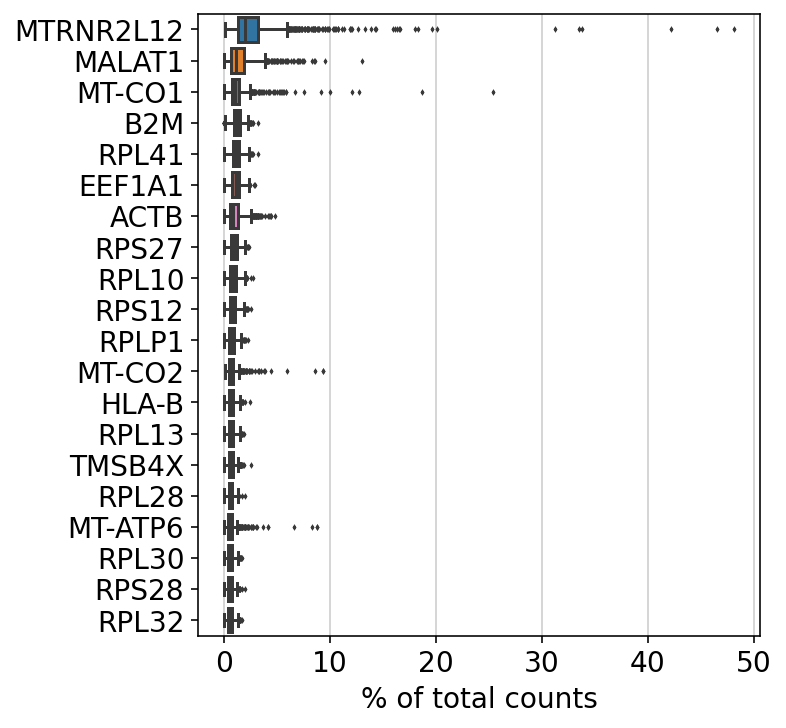

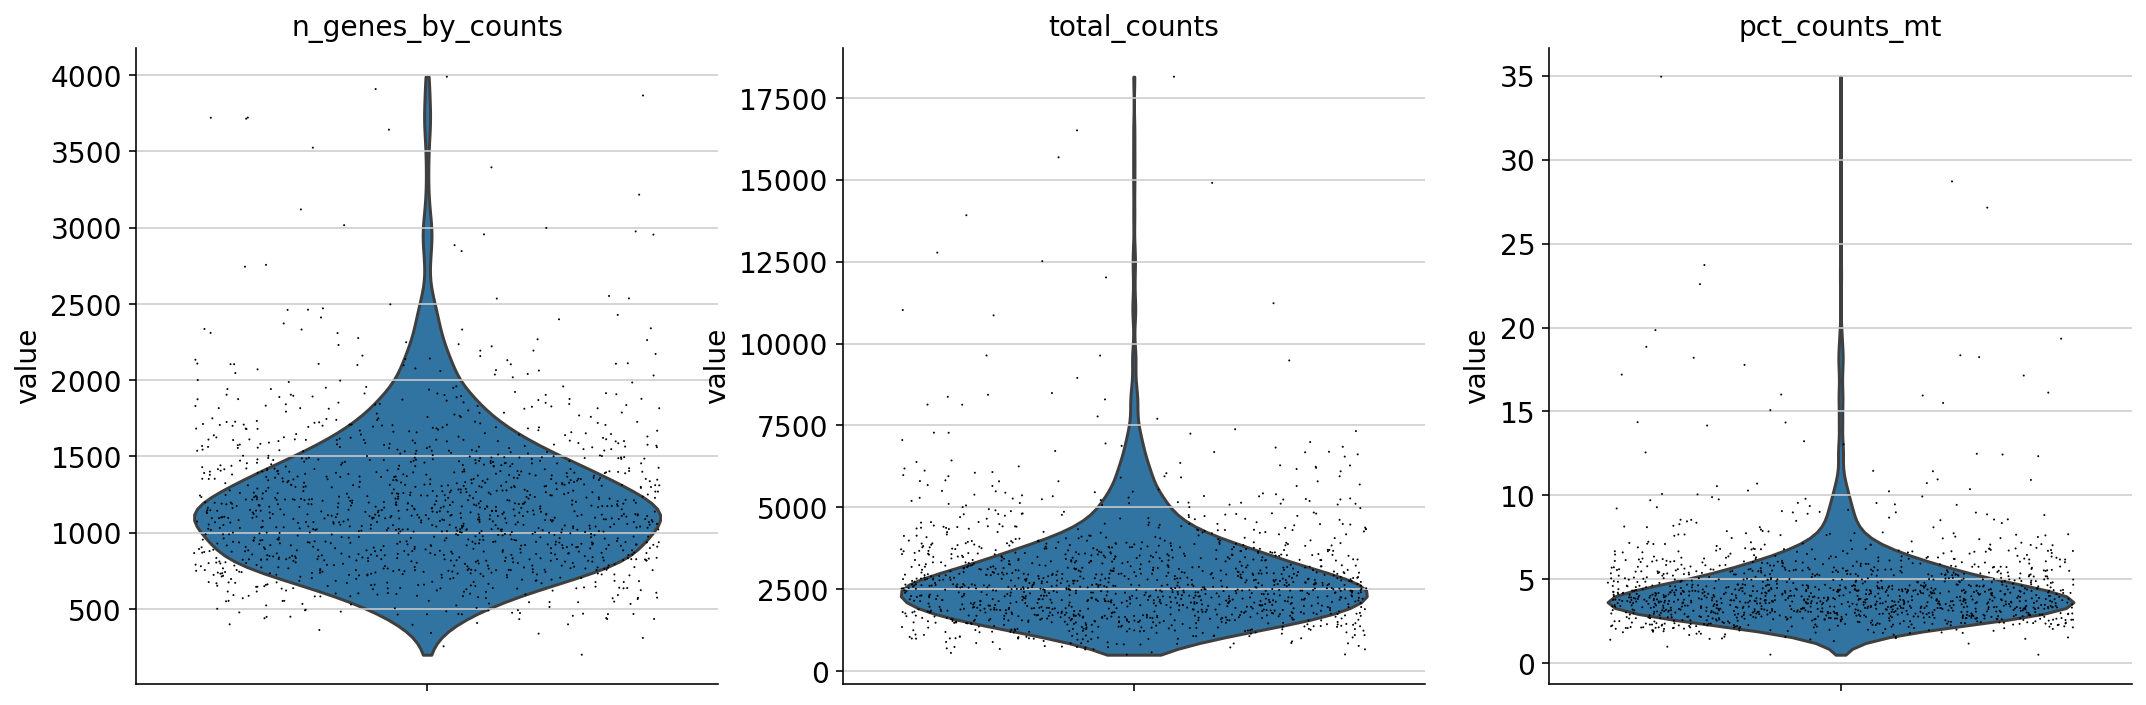

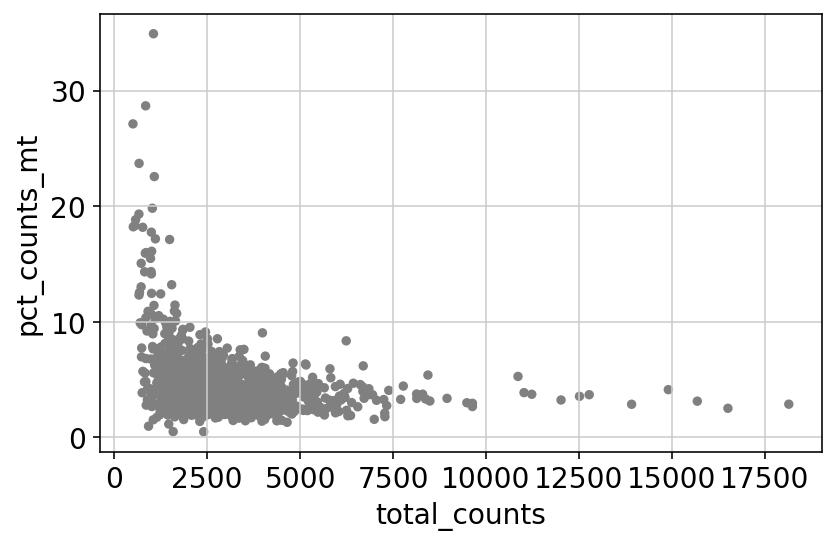

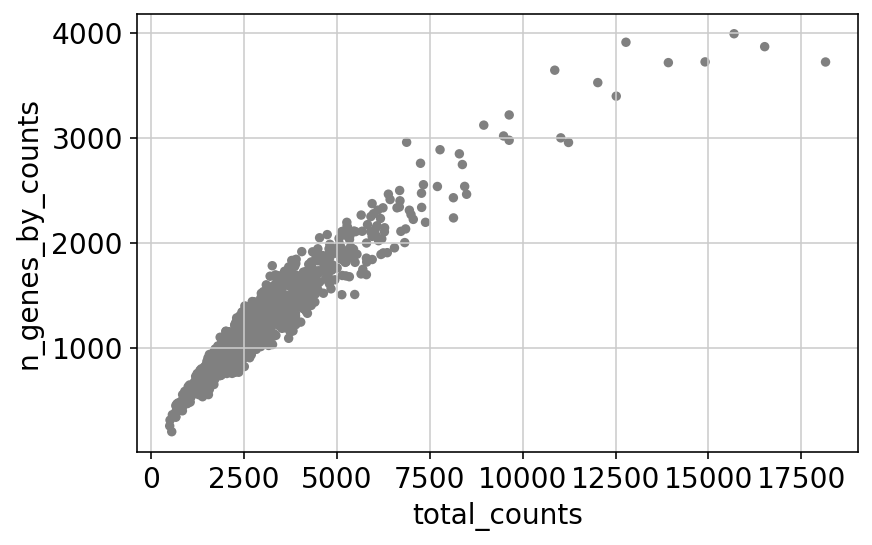

After filtering BP_01  cells with GEX: (1293, 13779)
PROCESSING...
BP_02  cells with tcr: (530, 0)
BP_02  cells with GEX: (930, 36601)


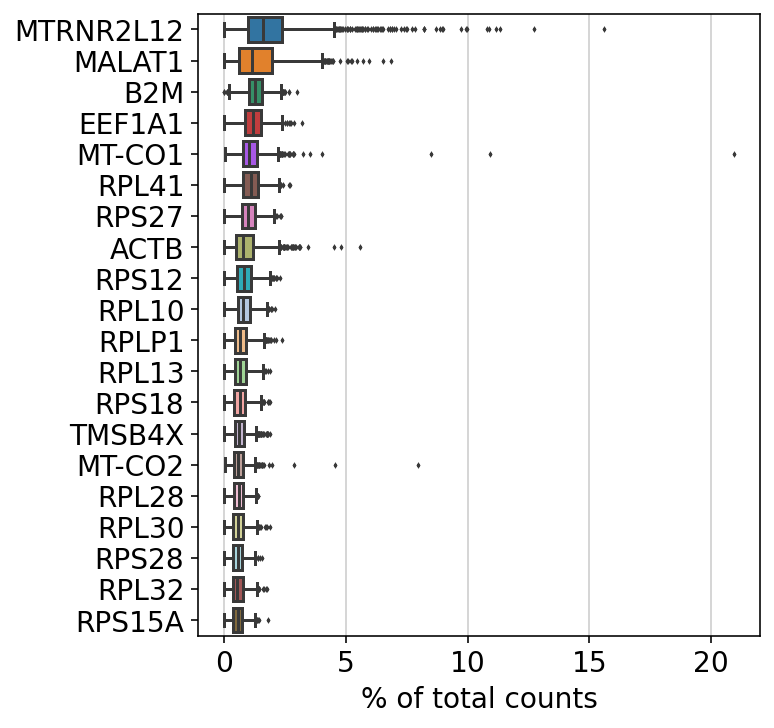

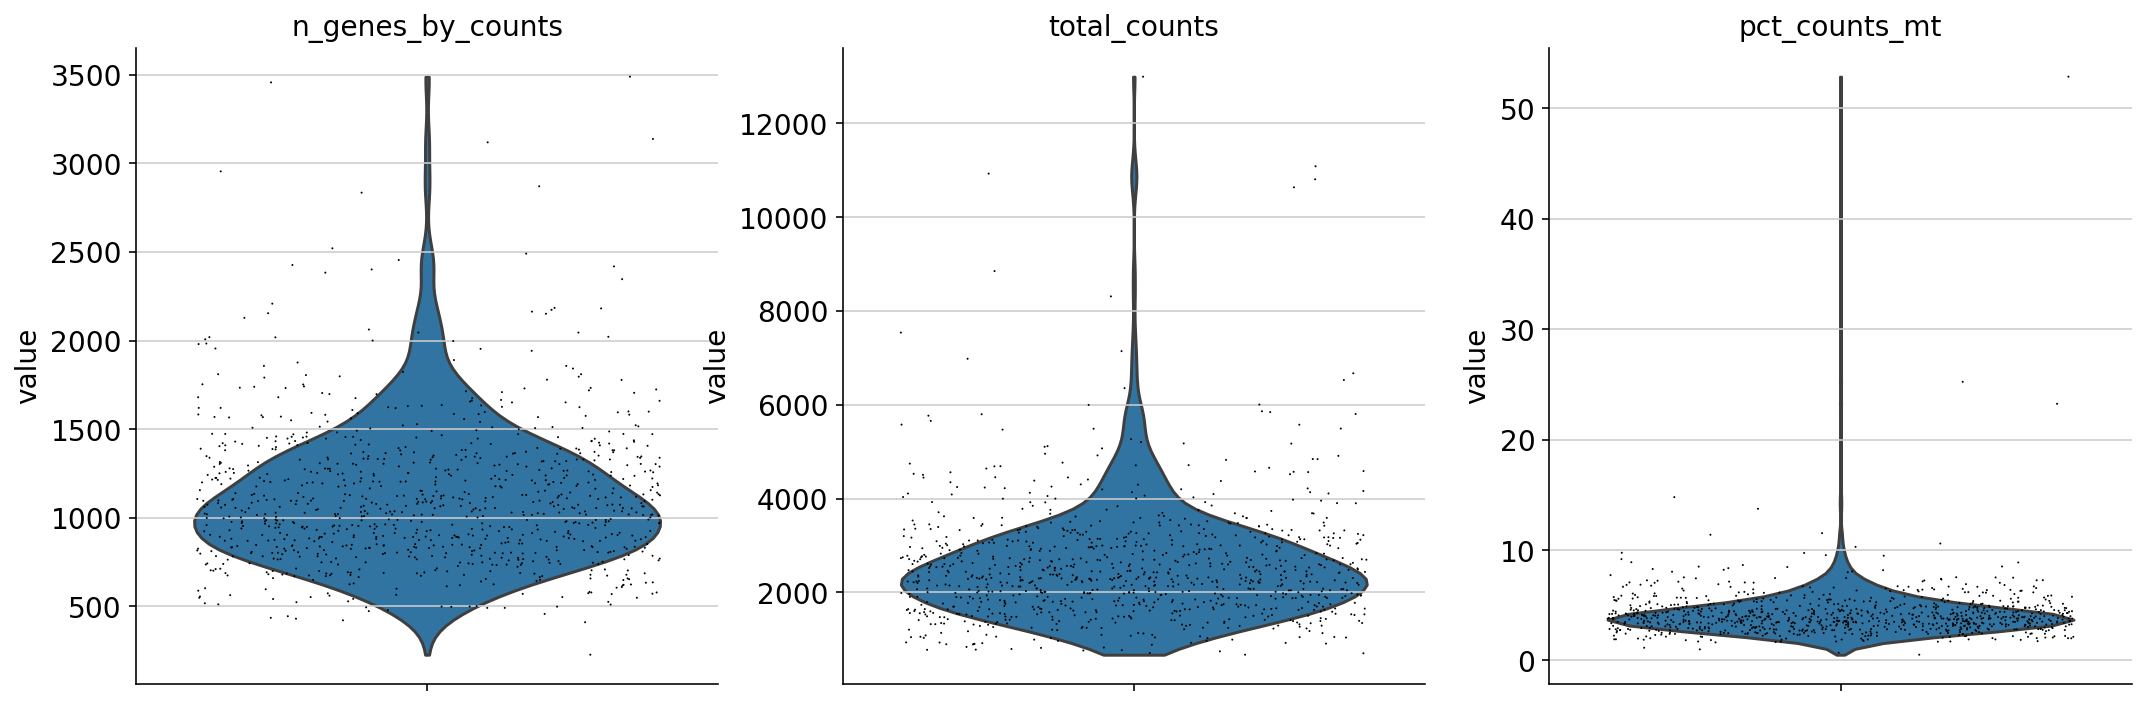

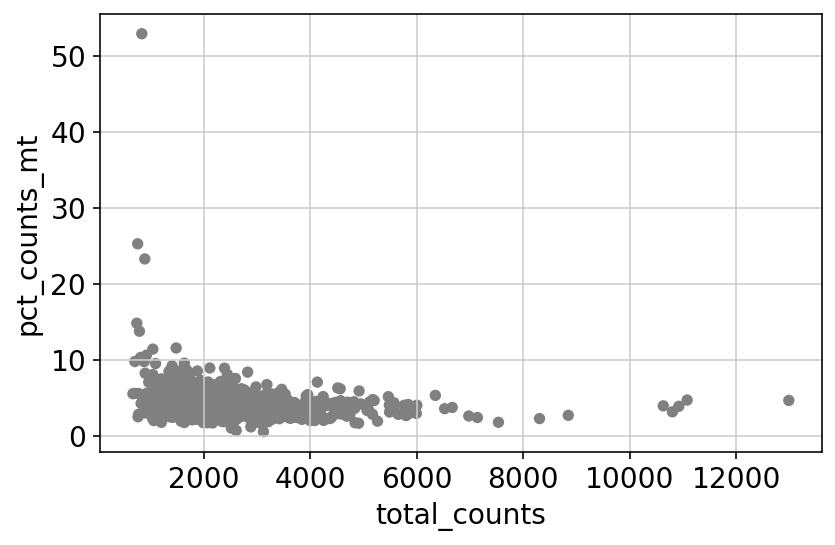

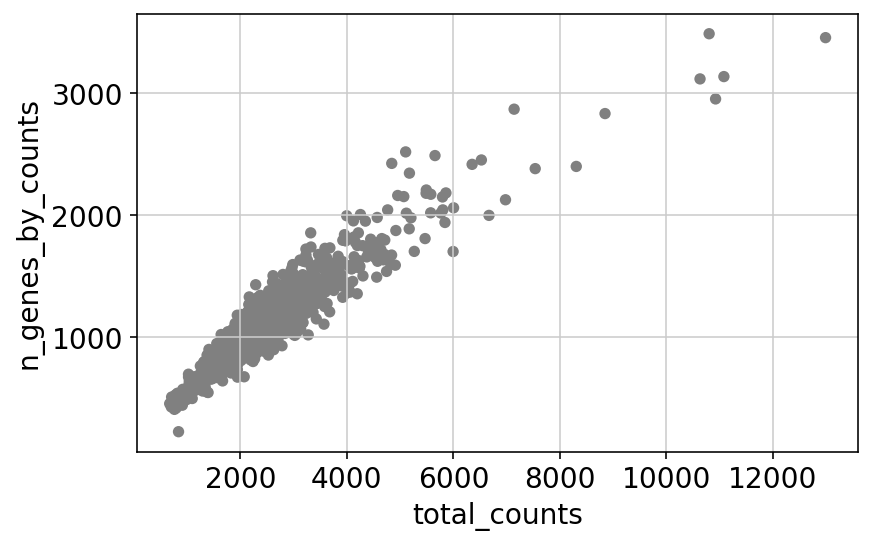

After filtering BP_02  cells with GEX: (916, 12867)
PROCESSING...
BP_03  cells with tcr: (222, 0)
BP_03  cells with GEX: (410, 36601)


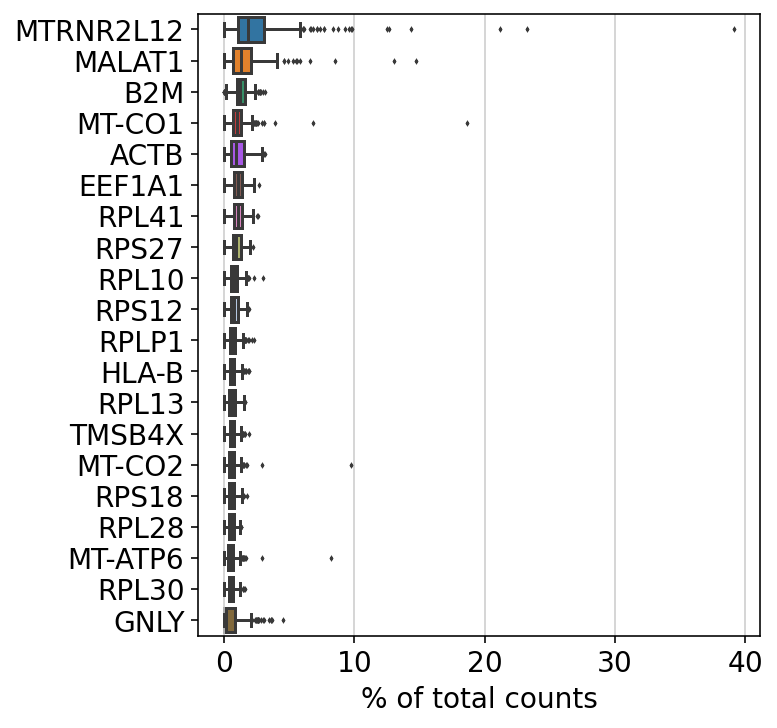

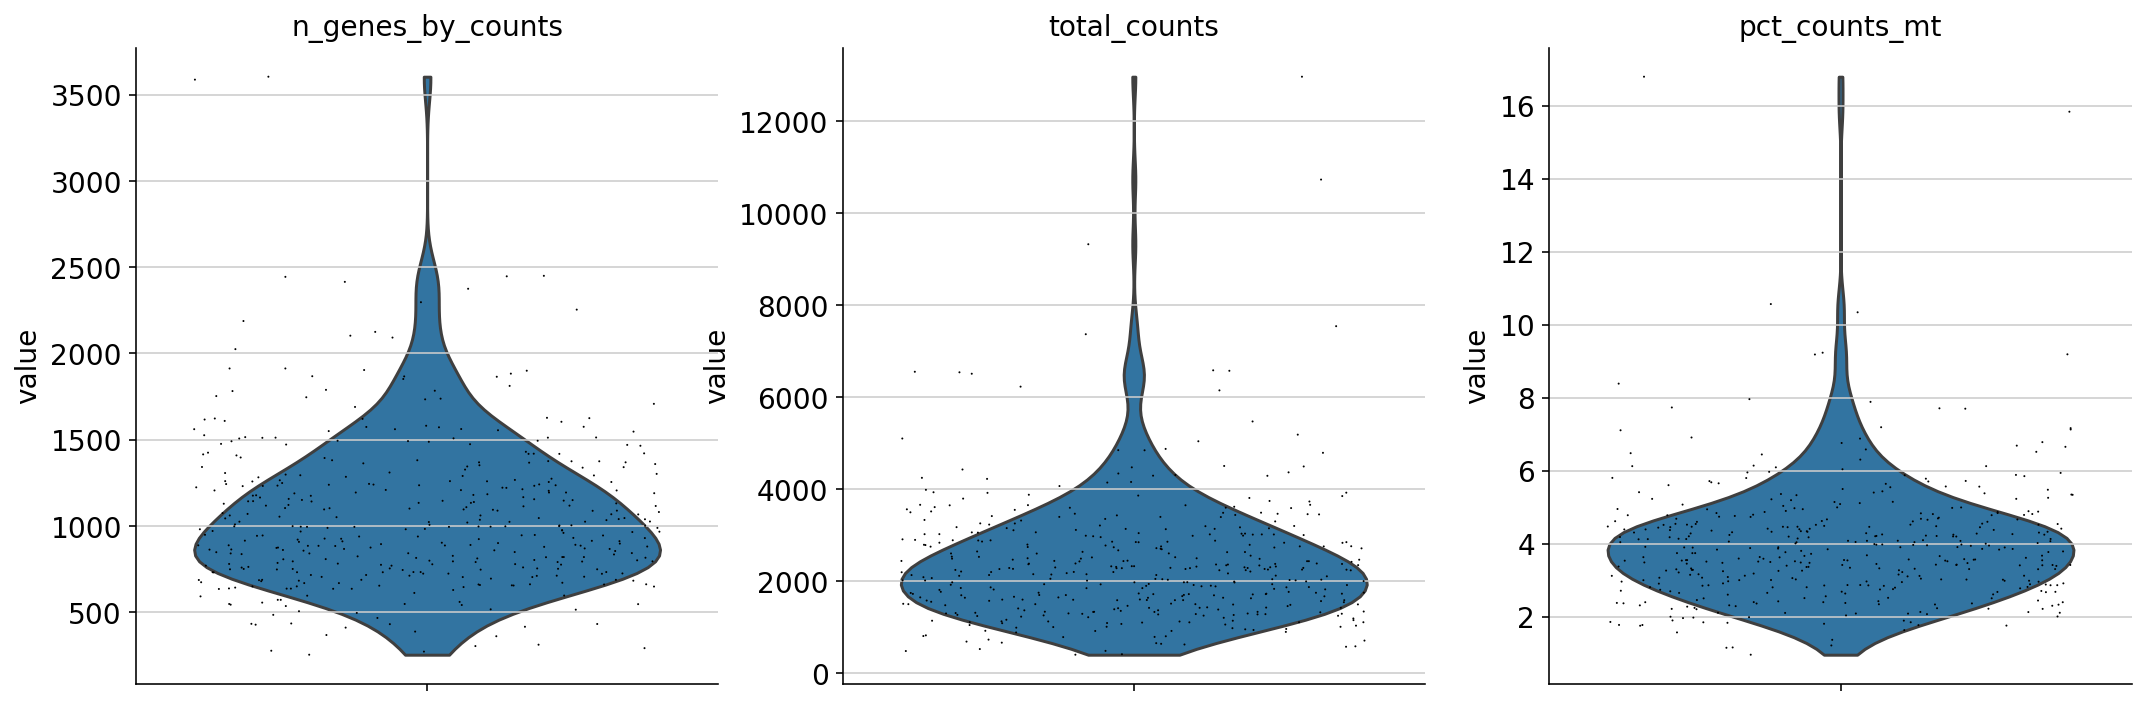

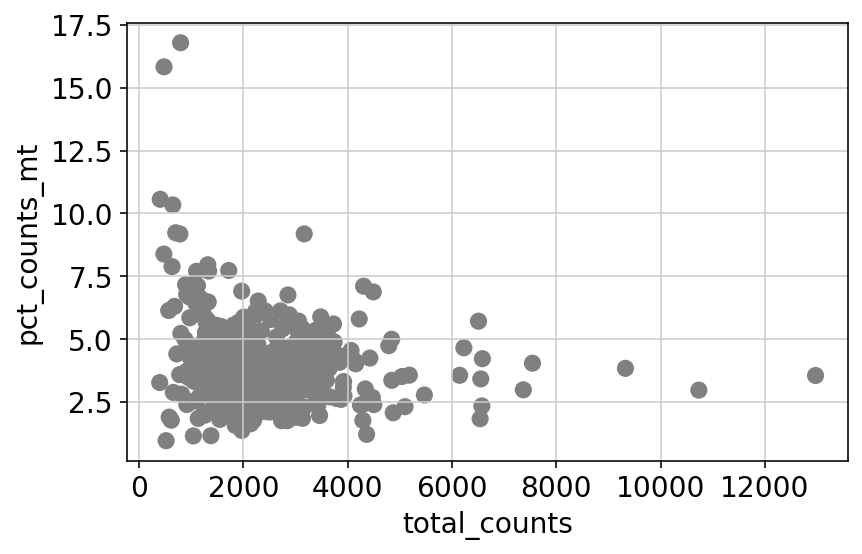

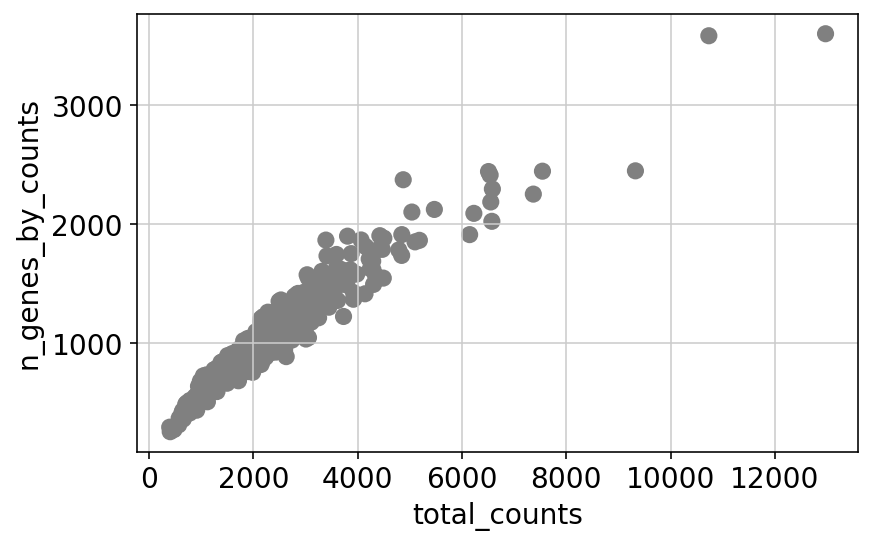

After filtering BP_03  cells with GEX: (400, 11023)


In [74]:
# Create a list of AnnData objects (one for each sample)
adatas = []
for sample, sample_meta in samples.items():
    print("PROCESSING...")
    # Load the associated transcriptomics data
    gex_file = glob(f"{data_dir}*{sample}*.h5")[0]
    adata = sc.read_10x_h5(gex_file)
    # Load the TCR data
    tcr_file = glob(f"{data_dir}*{sample}*airr*")[0] 
    adata_tcr = ir.io.read_airr(tcr_file)

    print(sample, " cells with tcr:", adata_tcr.shape)
    print(sample, " cells with GEX:", adata.shape)

    #Preprocessing
    adata.var_names_make_unique()
    sc.pl.highest_expr_genes(adata, n_top=20, save="_"+sample+"_highestGenes."+imageFormat)

    #basic filtering
    sc.pp.filter_cells(adata, min_genes=200) 
    sc.pp.filter_genes(adata, min_cells=3) 
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True, save="_"+sample+"_QCmetrics."+imageFormat)
    #Remove cells that have too many mitochondrial genes expressed or too many total counts:
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', save="_"+sample+"_UMI_mt."+imageFormat)
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', save="_"+sample+"_UMI_feat."+imageFormat)
    #Actually do the filtering by slicing the AnnData object
    adata = adata[adata.obs.n_genes_by_counts > 300, :]
    adata = adata[adata.obs.total_counts > 500, :]
    adata = adata[adata.obs.total_counts < 10000, :]
    adata = adata[adata.obs.pct_counts_mt < 10, :]

    print("After filtering", sample, " cells with GEX:", adata.shape)
    ir.pp.merge_with_ir(adata, adata_tcr)
    adata.obs["sample"] = sample
    adata.obs["group"] = sample_meta["group"]
    # concatenation only works with unique gene names
    adata.var_names_make_unique()
    adatas.append(adata)



#### Merge the samples, normalize, batch effect correction and UMAP

RNAseq: total cell number = (2609, 10797)


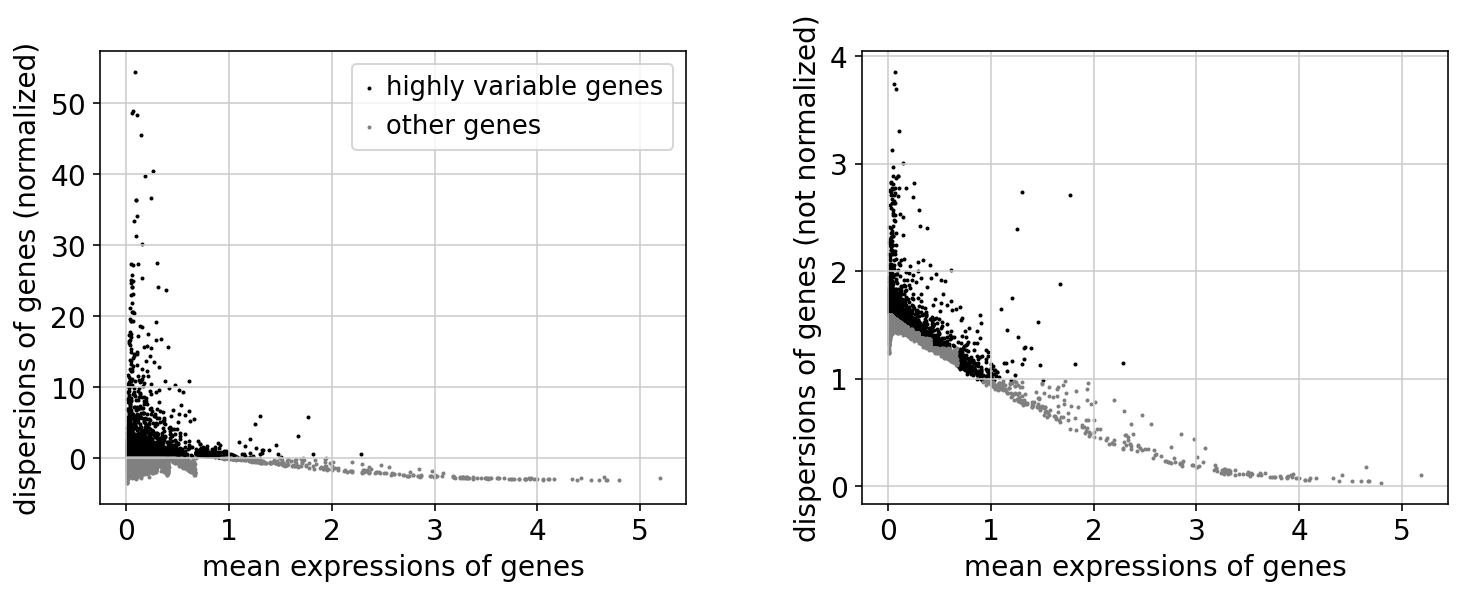

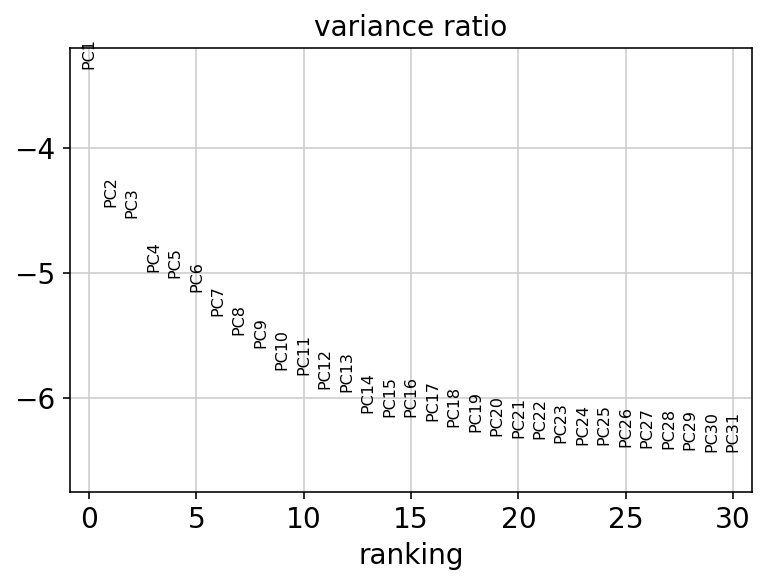

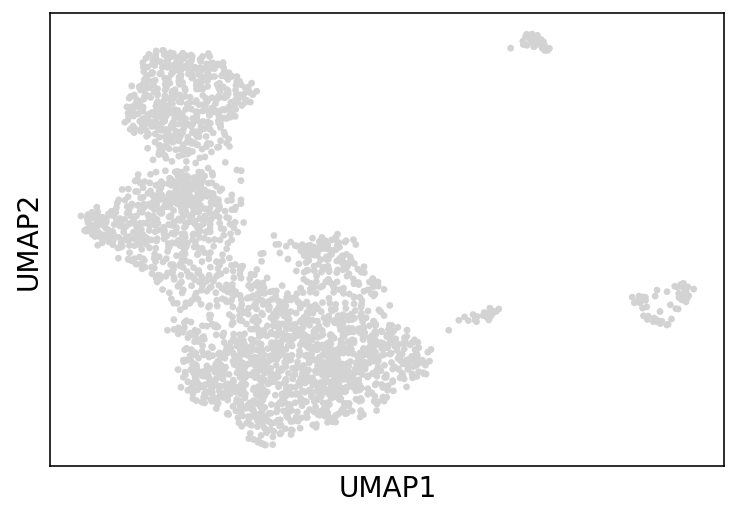

In [75]:
# Merge anndata objects
adata = anndata.concat(adatas)
adata.obs_names_make_unique()

print("RNAseq: total cell number =", adata.shape)

# normalize count
sc.pp.normalize_total(adata, target_sum=1e4)
# Log the data
sc.pp.log1p(adata)

#Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=5000)
sc.pl.highly_variable_genes(adata, save='.'+imageFormat)

#Reduce the dimensionality of the data by running principal component analysis (PCA),
# which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack')

#how many PCs to consider
sc.pl.pca_variance_ratio(adata, log=True, save='.'+imageFormat)

#Correcting bacth effect with BBKNN
sc.external.pp.bbknn(adata, batch_key='sample')  
#Embedding the neighborhood graph
sc.tl.umap(adata)
sc.pl.umap(adata)
#Clustering the neighborhood graph
sc.tl.leiden(adata, resolution=0.3)

### Make some UMAP plots

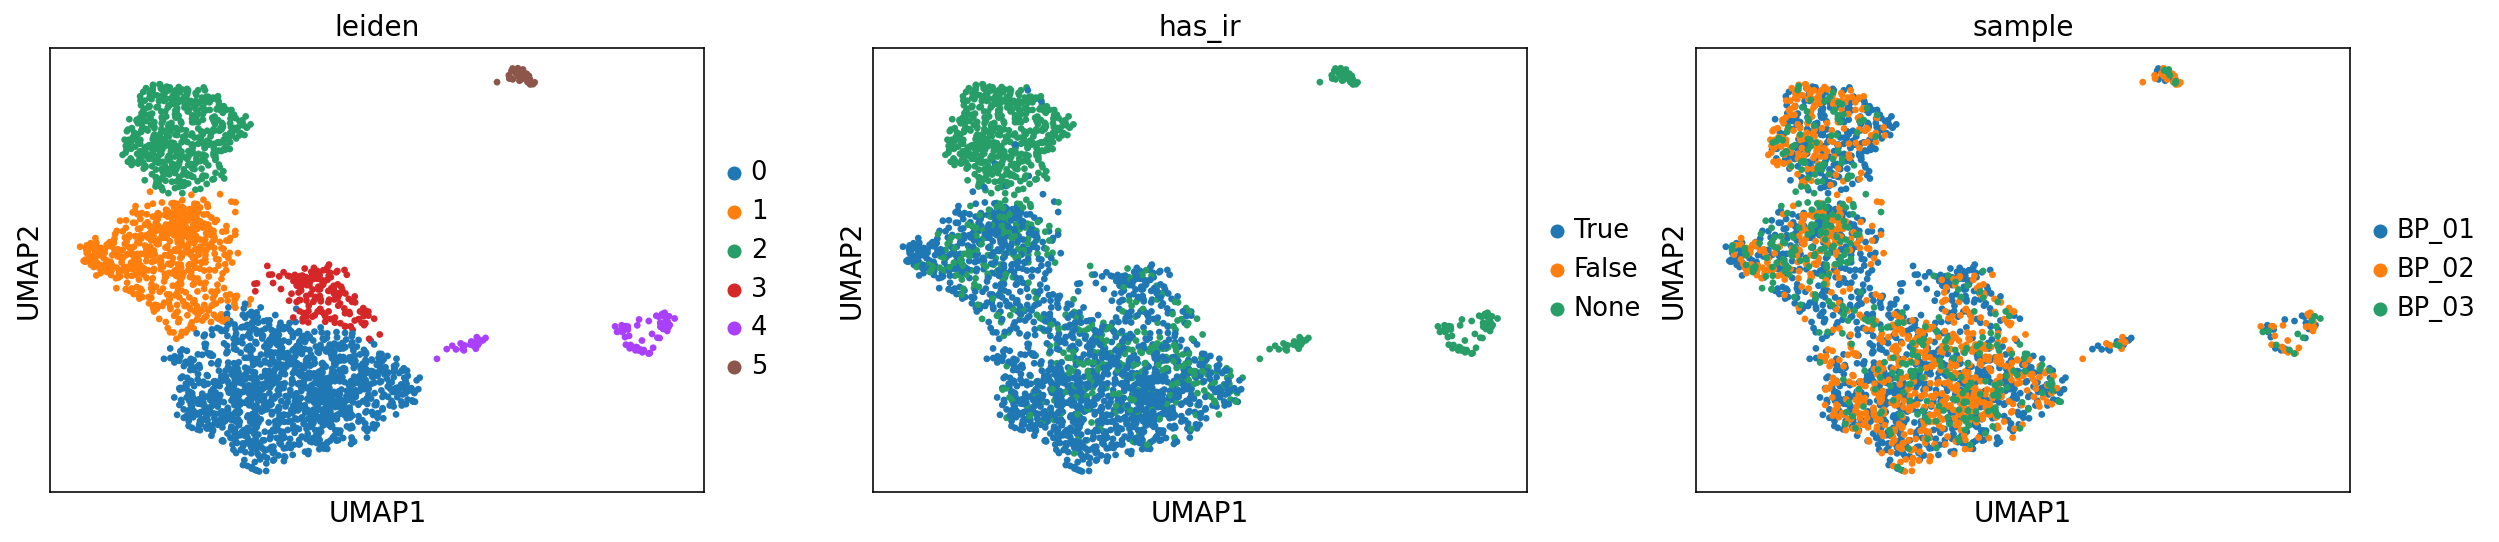

In [76]:
#Makes some plots
sc.pl.umap(adata, color=['leiden', 'has_ir', 'sample'], save='_withTCR_batch.'+imageFormat)


#### Identify marker genes

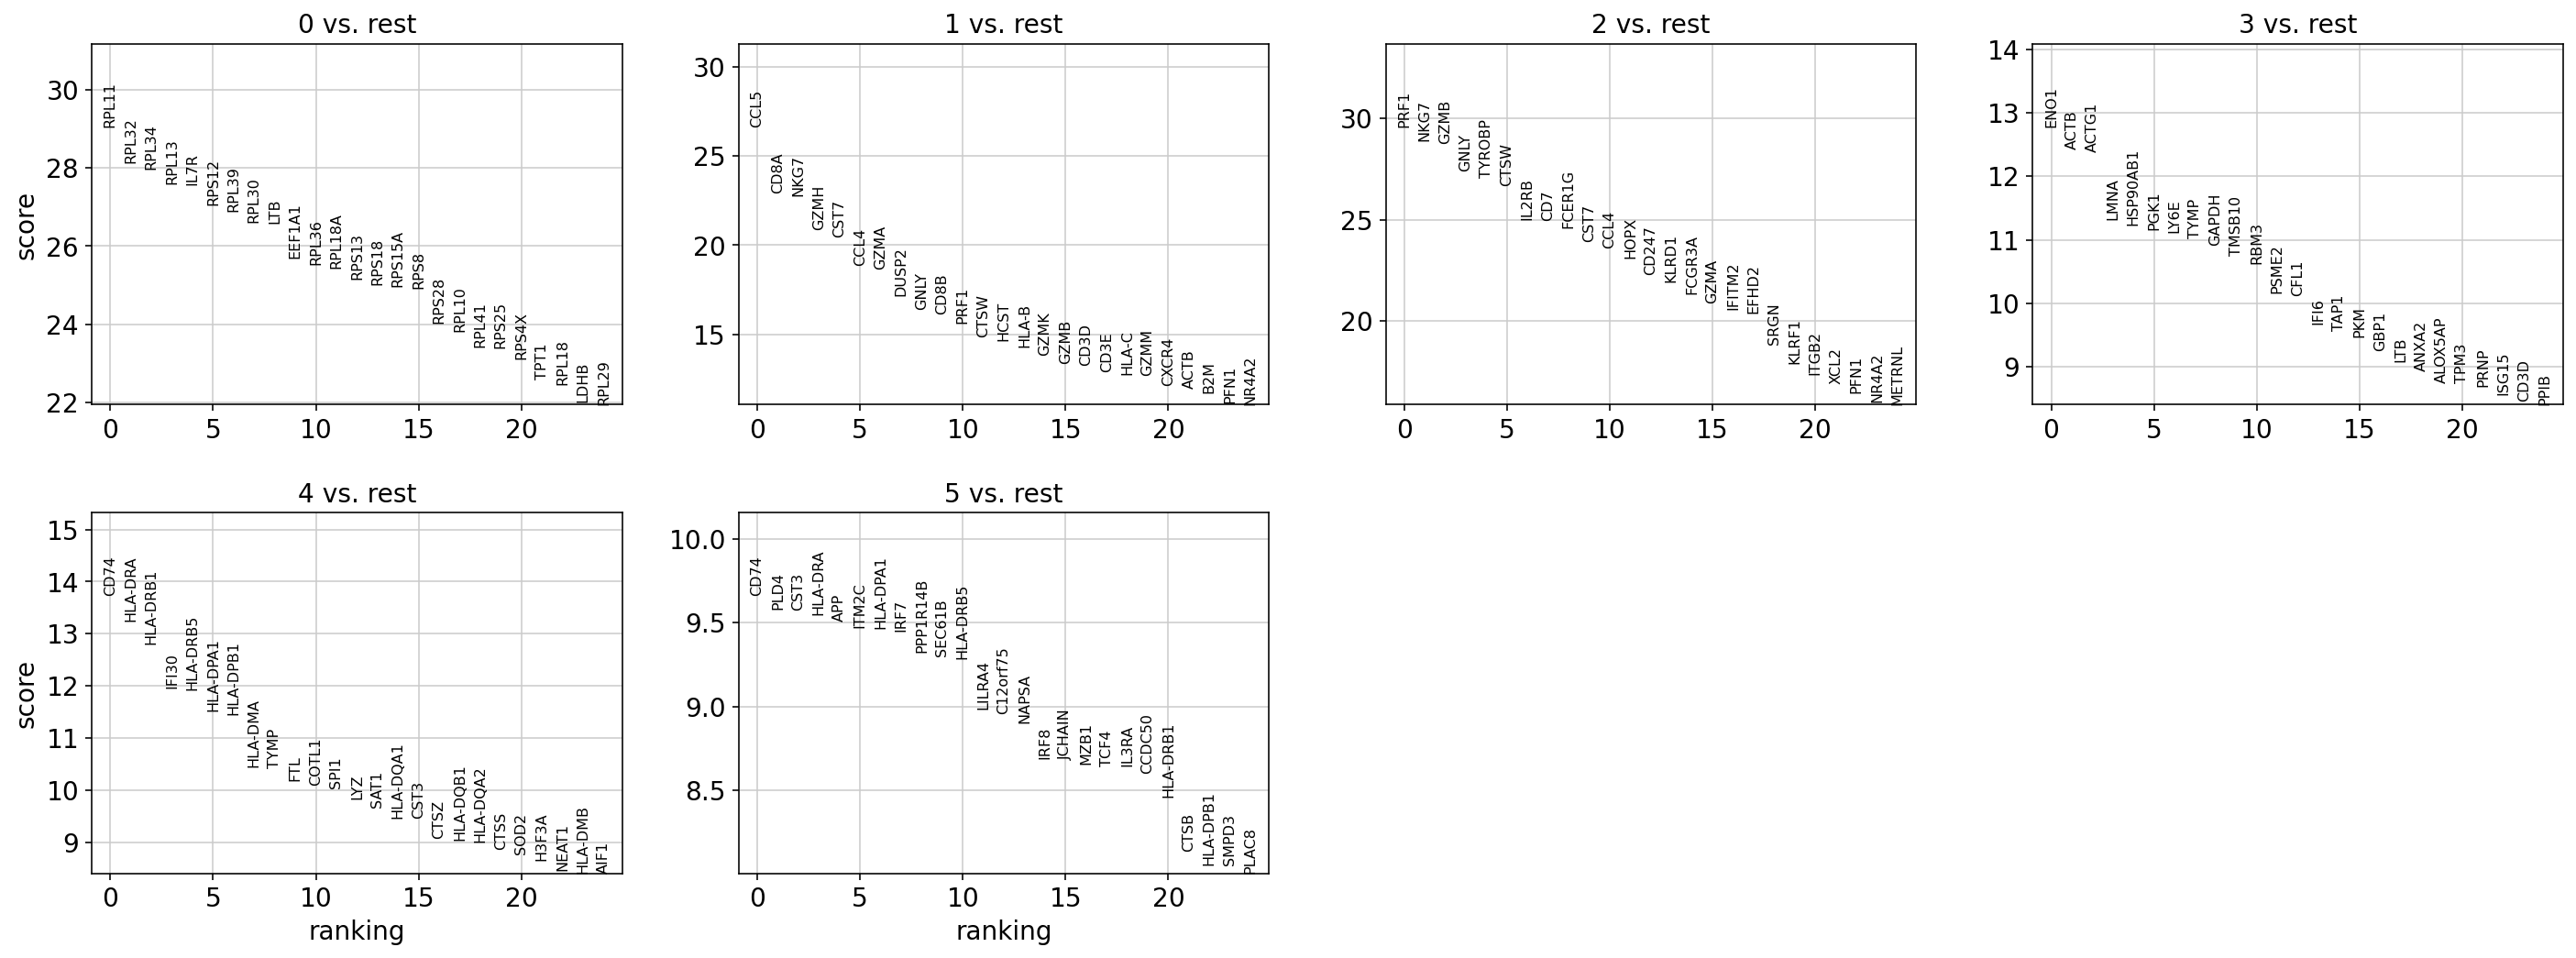

0     1       2         3         4        5
0  RPL11  CCL5    PRF1      ENO1      CD74     CD74
1  RPL32  CD8A    NKG7      ACTB   HLA-DRA     PLD4
2  RPL34  NKG7    GZMB     ACTG1  HLA-DRB1     CST3
3  RPL13  GZMH    GNLY      LMNA     IFI30  HLA-DRA
4   IL7R  CST7  TYROBP  HSP90AB1  HLA-DRB5      APP

In [77]:

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save='.'+imageFormat)
results_file = out_dir+"annData.hdf5"
adata.X = csr_matrix(adata.X)

#get a tabale with the scores and goupr
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']}).head(25) #pvals
#save to a file
df.to_csv(fr"{out_dir}clusters_markers_top25.tsv", index=None, sep='\t', mode='a')

#show the top 5 markers in a data frame
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5))
#get a tabale with the scores and goupr
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)
#save to a file
df.to_csv(fr"{out_dir}clusters_markers.tsv", index=None, sep='\t', mode='a')





#### Identify the different cell populations

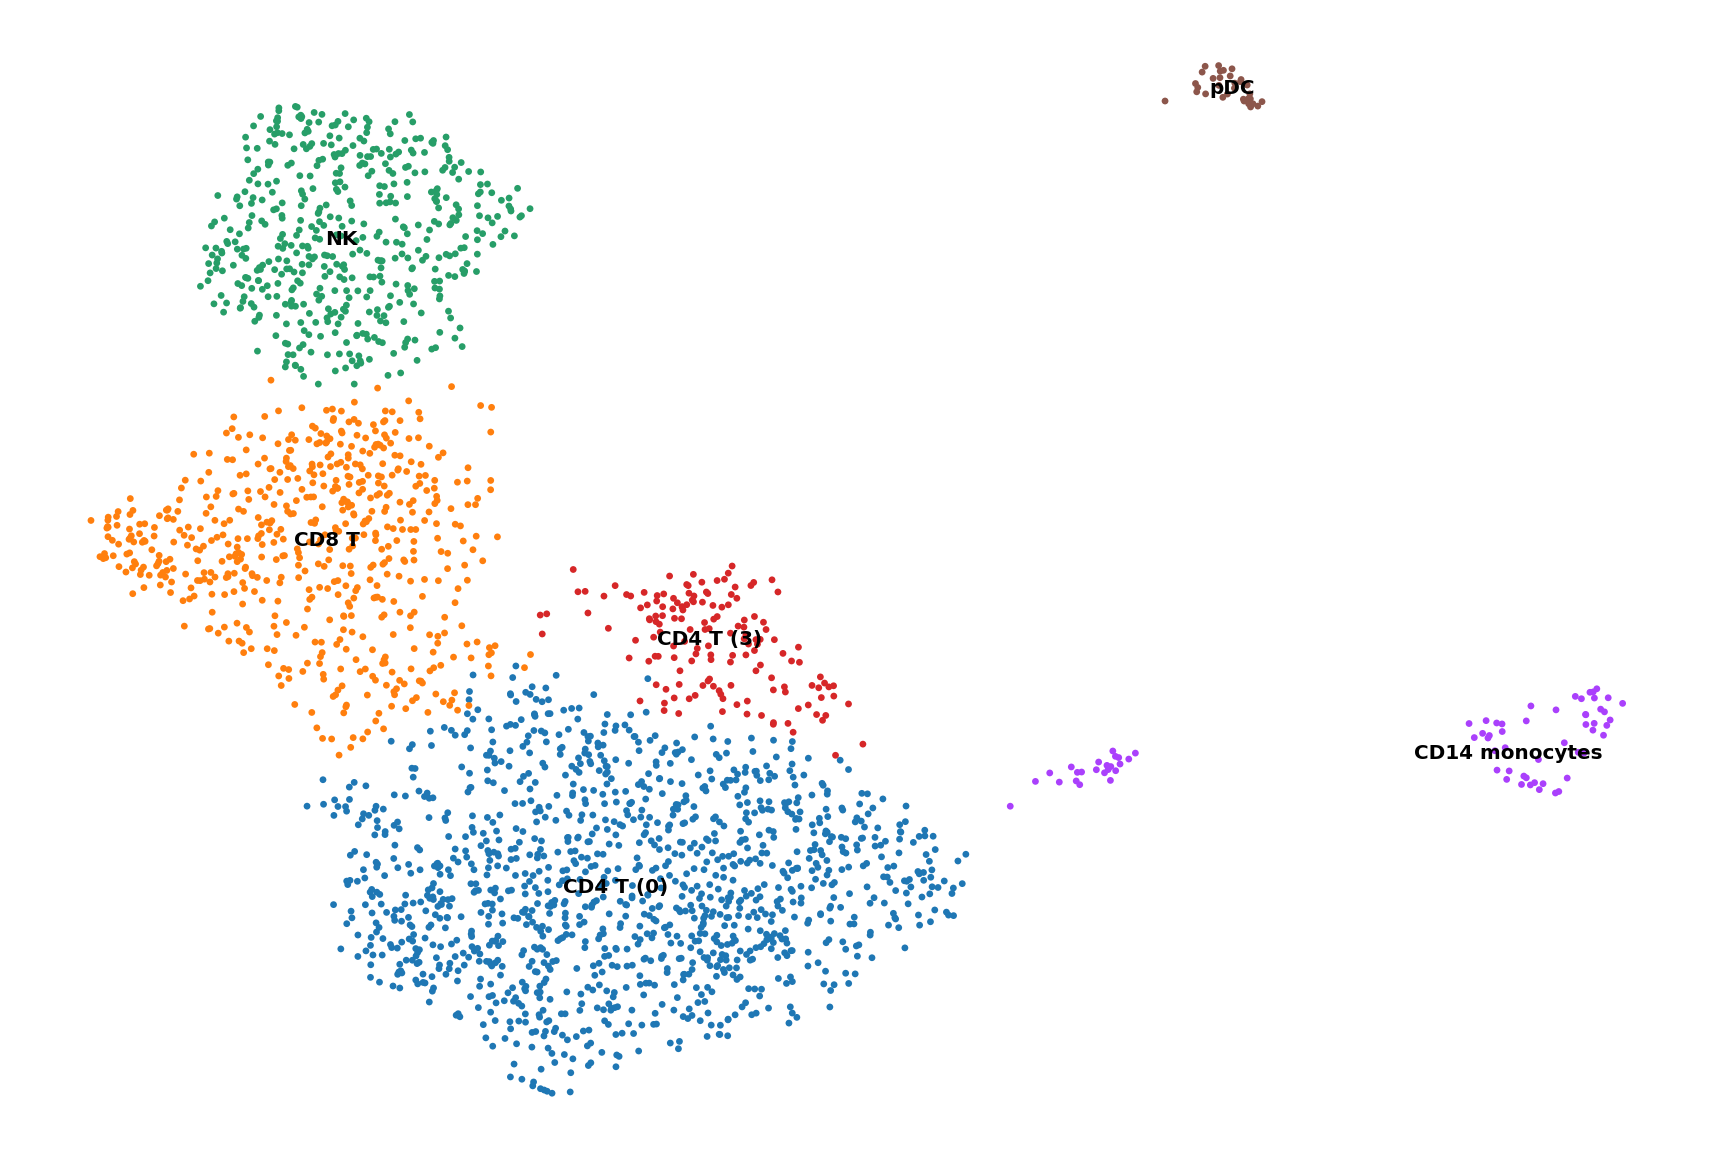

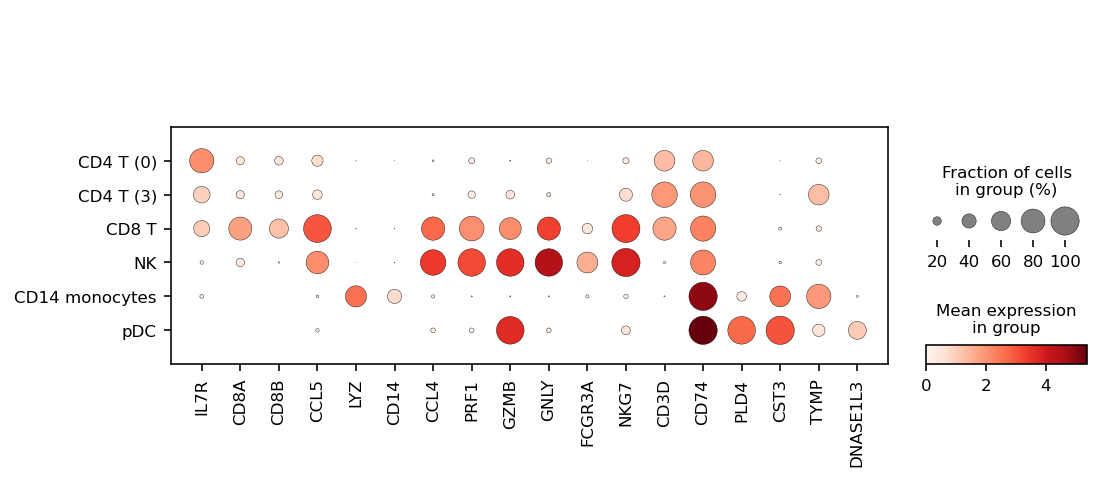

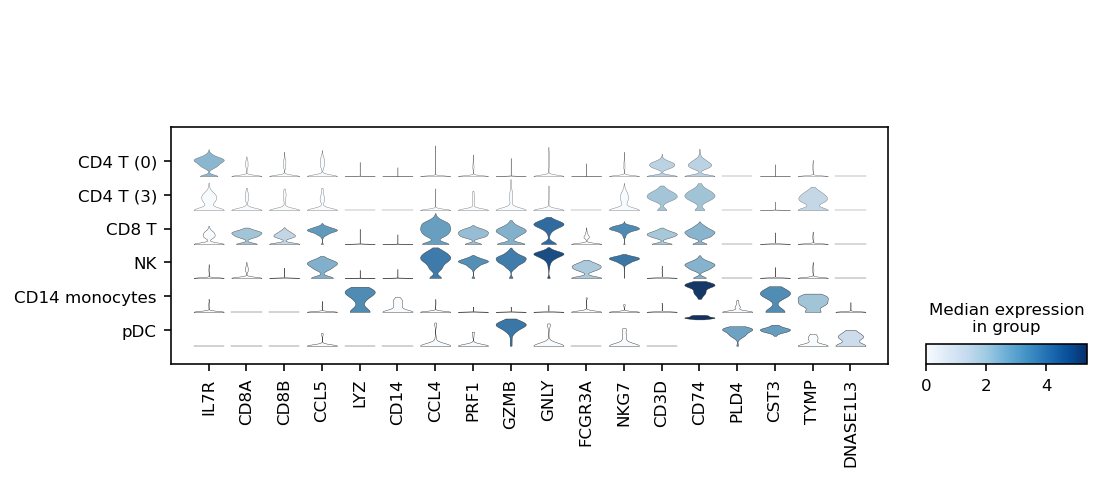

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 18
📂 Storing models in /home/localadmin/.celltypist/data/models
💾 Downloading model [1/18]: Immune_All_Low.pkl
💾 Downloading model [2/18]: Immune_All_High.pkl
💾 Downloading model [3/18]: Adult_Mouse_Gut.pkl
💾 Downloading model [4/18]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [5/18]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/18]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/18]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/18]: Cells_Lung_Airway.pkl
💾 Downloading model [9/18]: Developing_Human_Brain.pkl
💾 Downloading model [10/18]: Developing_Human_Thymus.pkl
💾 Downloading model [11/18]: Developing_Mouse_Brain.pkl
💾 Downloading model [12/18]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [13/18]: Human_IPF_Lung.pkl
💾 Downloading model [14/18]: Human_Lung_Atlas.pkl
💾 Downloading model [15/18]: Human_PF_Lung.pkl
💾 Downloading model [16/18]: Lethal_COVID19_Lun

model  \
0             Immune_All_Low.pkl   
1            Immune_All_High.pkl   
2            Adult_Mouse_Gut.pkl   
3       Autopsy_COVID19_Lung.pkl   
4   COVID19_Immune_Landscape.pkl   
5           Cells_Fetal_Lung.pkl   
6     Cells_Intestinal_Tract.pkl   
7          Cells_Lung_Airway.pkl   
8     Developing_Human_Brain.pkl   
9    Developing_Human_Thymus.pkl   
10    Developing_Mouse_Brain.pkl   
11      Healthy_COVID19_PBMC.pkl   
12            Human_IPF_Lung.pkl   
13          Human_Lung_Atlas.pkl   
14             Human_PF_Lung.pkl   
15       Lethal_COVID19_Lung.pkl   
16        Nuclei_Lung_Airway.pkl   
17           Pan_Fetal_Human.pkl   

                                          description  
0   immune sub-populations combined from 20 tissue...  
1   immune populations combined from 20 tissues of...  
2   cell types in the adult mouse gut combined fro...  
3   cell types from the lungs of 16 SARS-CoV-2 inf...  
4   immune subtypes from lung and blood of COVID-1...  
5     cell types from human embryonic and fetal lungs  
6   intestinal cells from fetal, pediatric (health...  
7   cell populations from scRNA-seq of five locati...  
8   cell types from the first-trimester developing...  
9   cell populations in embryonic, fetal, pediatri...  
10  cell types from the embryonic mouse brain betw...  
11  peripheral blood mononuclear cell types from h...  
12  cell types from idiopathic pulmonary fibrosis,...  
13  integrated Human Lung Cell Atlas (HLCA) combin...  
14  cell types from different forms of pulmonary f...  
15  cell types from the lungs of individuals who d...  
16  cell populations from snRNA-seq of five locati...  
17  stromal and immune populations from the human ...

🔬 Input data has 2609 cells and 10797 genes
🔗 Matching reference genes in the model
🧬 3769 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


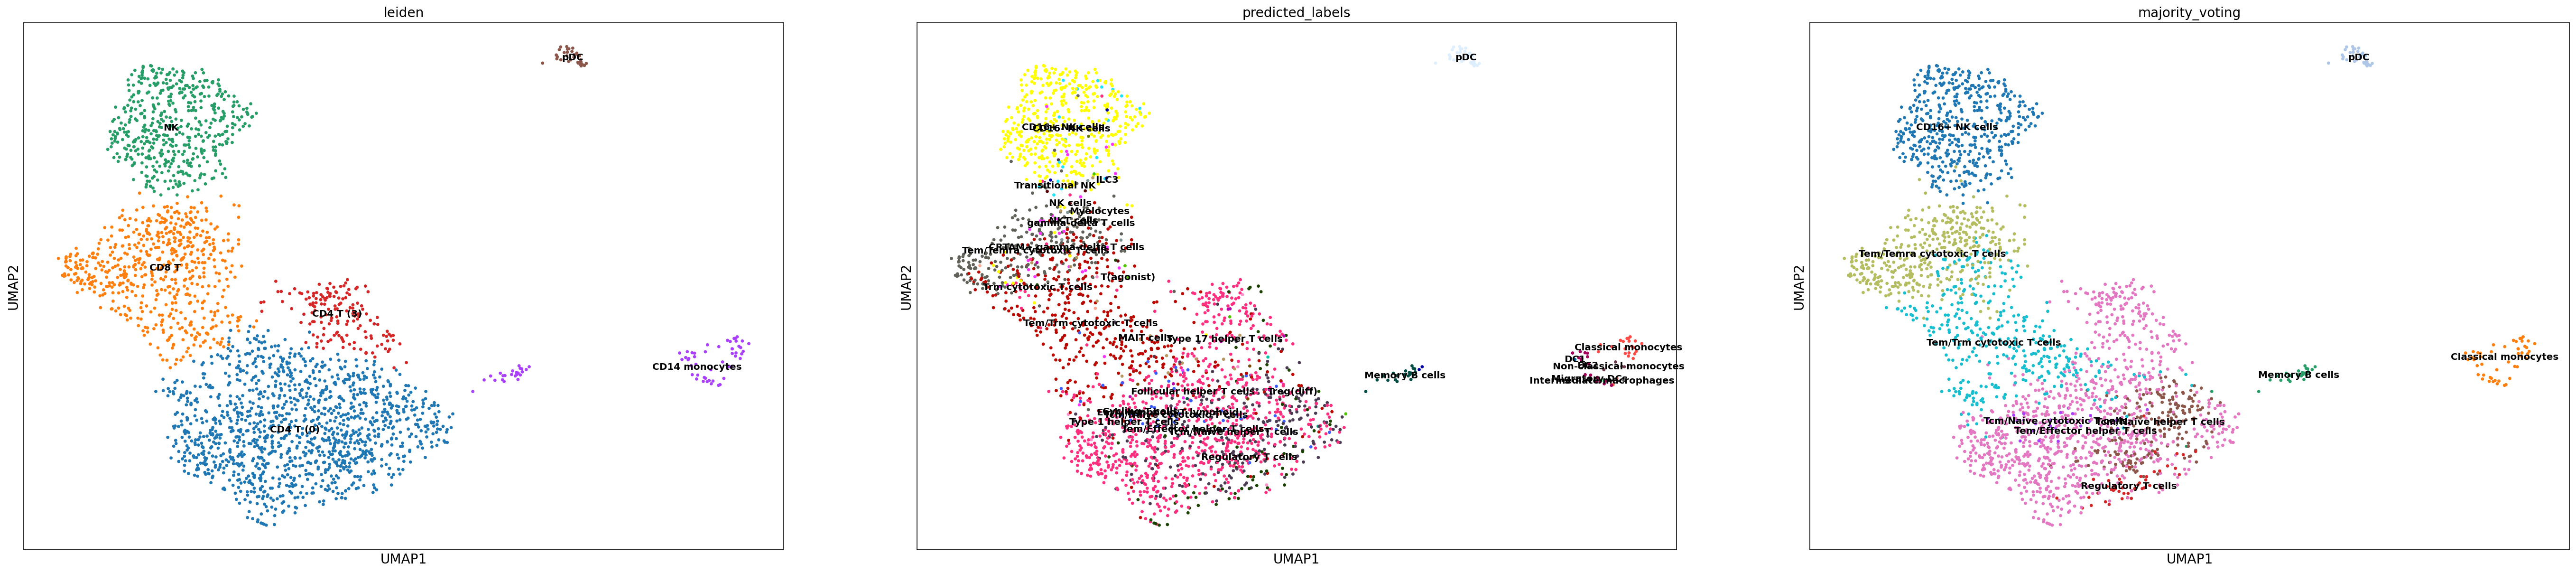

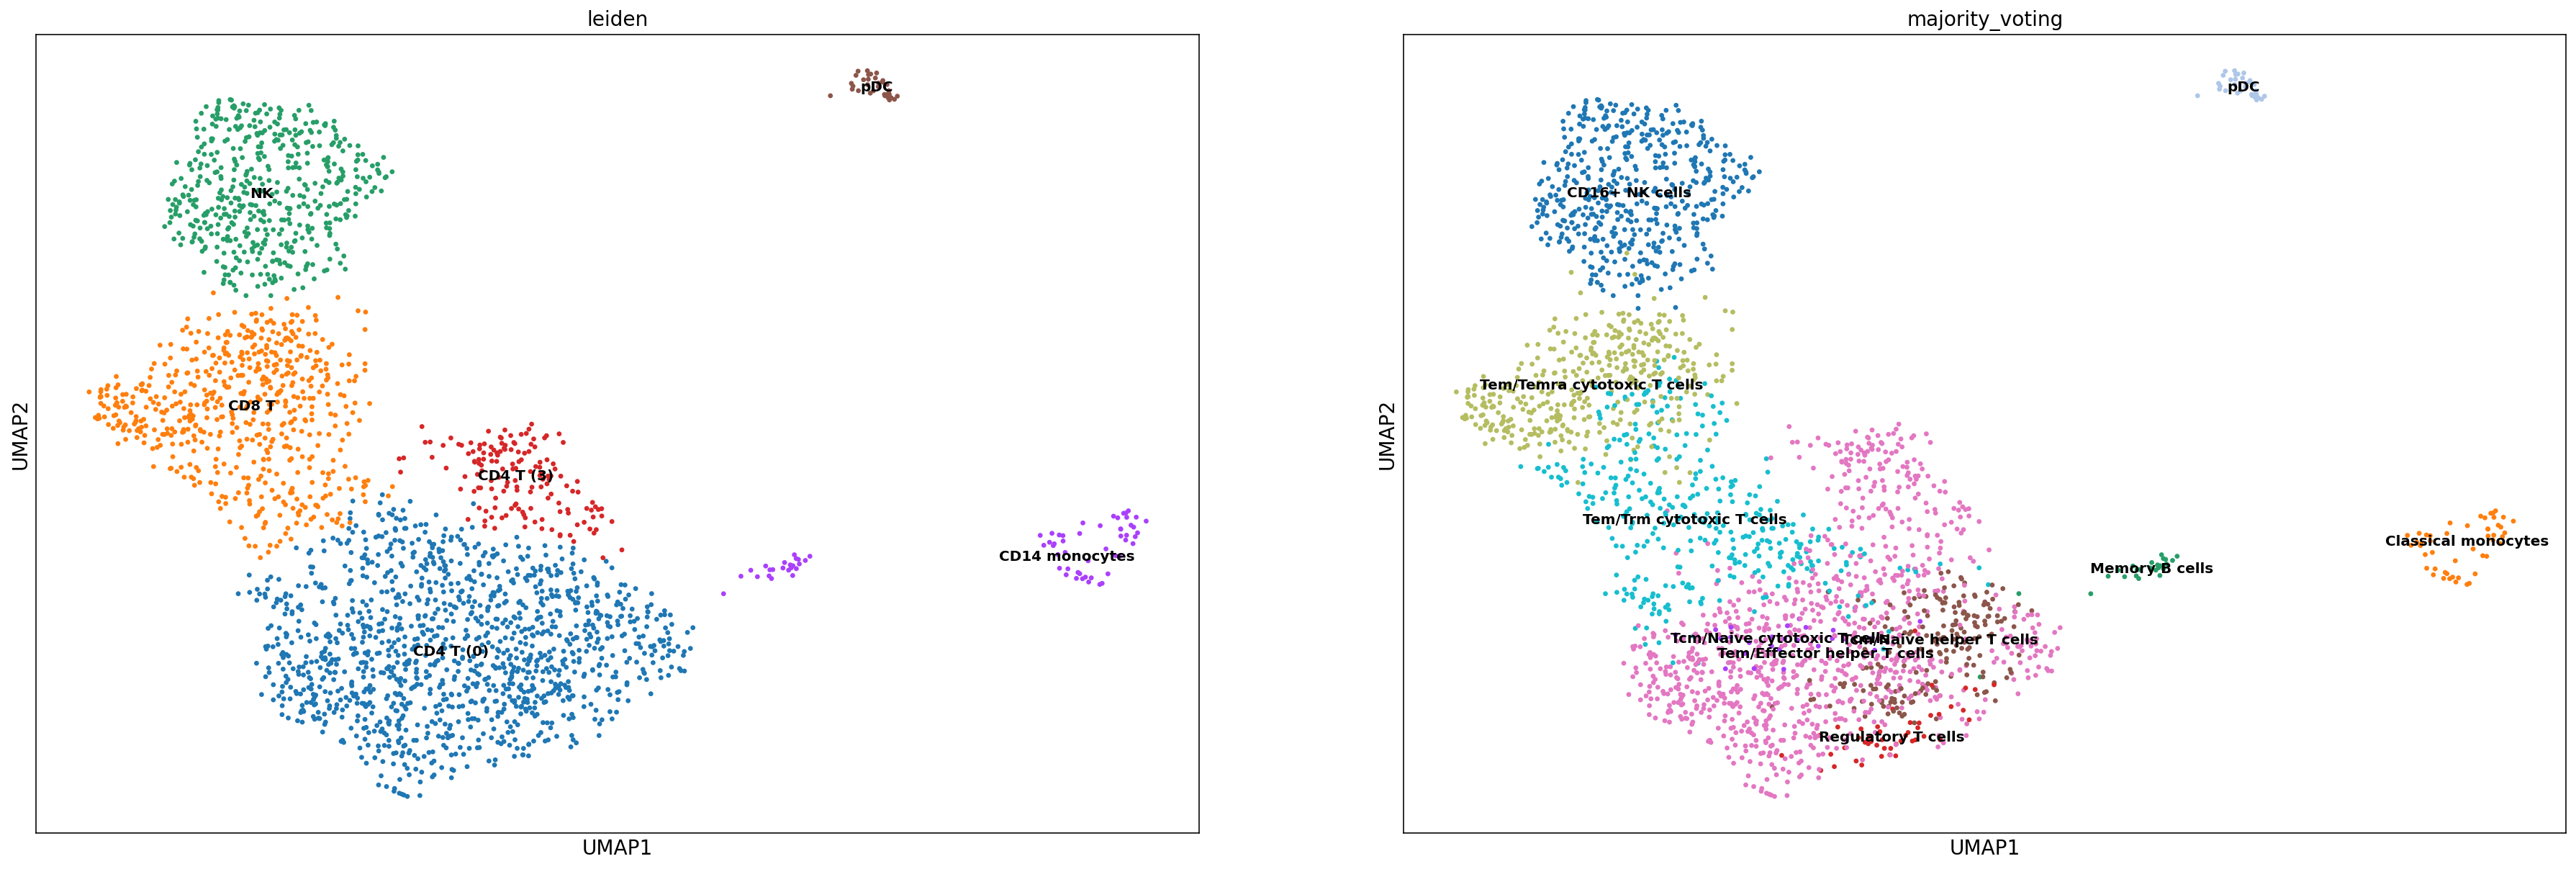

In [83]:

#Mark the cell type
new_cluster_names = [
    'CD4 T (0)',
    'CD8 T', 'NK',
    'CD4 T (3)', 'CD14 monocytes',
    'pDC']

adata.obs['leiden'] = adata.obs['leiden'].cat.rename_categories(new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='_withClusterNames.png')

#Set manually the marker genes of the different clusters
marker_genes = ['IL7R', 'CD8A', 'CD8B', 'CCL5',  'LYZ', 'CD14',
                'CCL4', 'PRF1', 'GZMB', 'GNLY', 'FCGR3A', 'NKG7', 'CD3D',
                'CD74', 'PLD4', 'CST3', 'TYMP',
                'DNASE1L3',
                ] 
#Visualize the marker genes
sc.pl.dotplot(adata, marker_genes, categories_order=[ 'CD4 T (0)', 'CD4 T (3)','CD8 T', 'NK', 'CD14 monocytes','pDC'],
              groupby='leiden', save='_markers.'+imageFormat)
#as compact violin plots
sc.pl.stacked_violin(adata, marker_genes, categories_order=[ 'CD4 T (0)', 'CD4 T (3)','CD8 T', 'NK', 'CD14 monocytes','pDC'],
                     groupby='leiden', rotation=90, save='_markers.'+imageFormat)


#Use CellTypist to annotate the data (www.celltypist.org)
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)
#Show all available models that can be downloaded and used.
display(models.models_description())
#Download a specific model, for example, `Immune_All_Low.pkl`.
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')
model.cell_types
model.description
# specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True)

predictions.predicted_labels
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata_with_prediction = predictions.to_adata()
#visualize the prediction
sc.pl.umap(adata_with_prediction, color = ['leiden', 'predicted_labels', 'majority_voting'], legend_loc = 'on data',
           save='_PREDICTIONS.'+imageFormat)

sc.pl.umap(adata_with_prediction, color = ['leiden',  'majority_voting'], legend_loc = 'on data',
           save='_PREDICTIONS_V2.'+imageFormat,)


#### Generate UMAP plot with CellTypist annotation

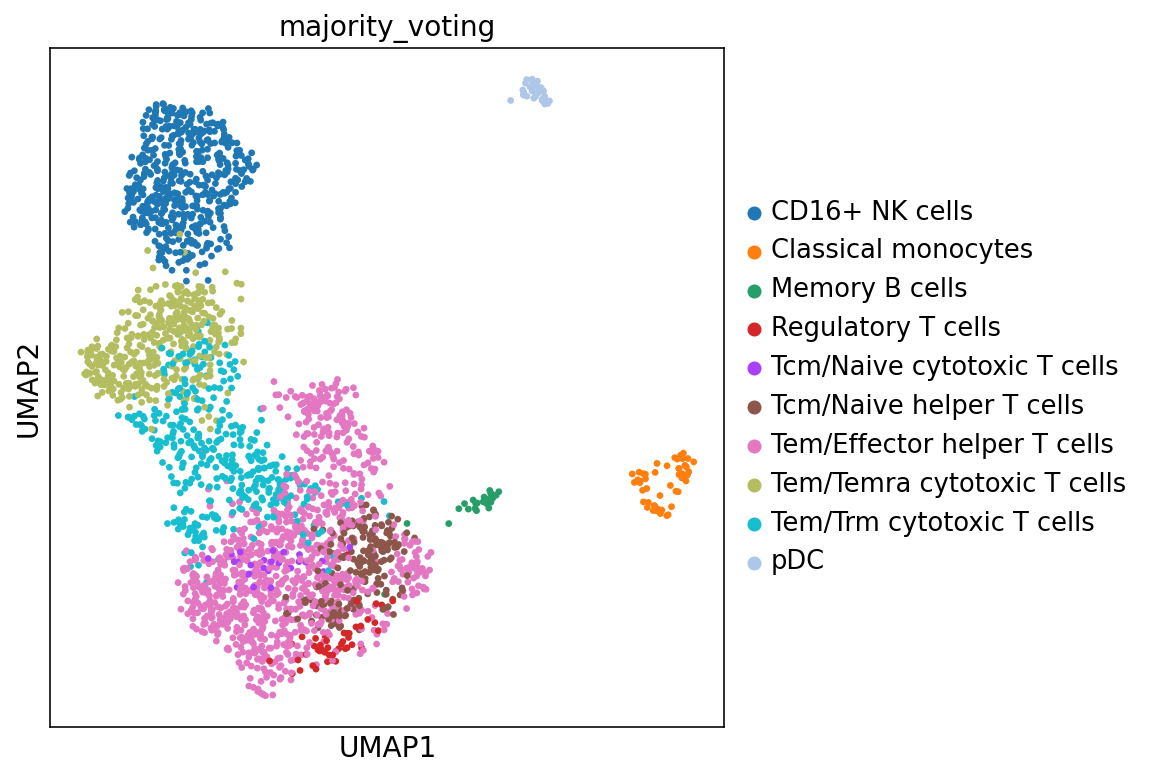

In [79]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_with_prediction, color = ['majority_voting'],
           save='_10X_CELLTYPIST.'+imageFormat,)


#### Generate a Dotplot of markers with cellTypist annotation

In [80]:
#to plot the repartition of cell by donors
#counts = adata.obs['majority_voting'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
#print(counts)
anndatacopy=adata.copy()
anndatacopy2=adata.copy()
anndatacopy.obs.groupby(['sample'])['majority_voting']\
   .value_counts(normalize=True)\
   .unstack()\
   .mul(100)\
   .round(2)\
   .fillna(0)
anndatacopy2.obs.groupby(['sample'])['majority_voting']\
   .value_counts()\
   .unstack()\
   .round(2)\
   .fillna(0)

CD16+ NK cells  Classical monocytes  Memory B cells  \
sample                                                        
BP_01              251                   19              16   
BP_02              171                   20               7   
BP_03               71                   10               2   

        Regulatory T cells  Tcm/Naive cytotoxic T cells  \
sample                                                    
BP_01                   25                           16   
BP_02                   12                            4   
BP_03                    9                            7   

        Tcm/Naive helper T cells  Tem/Effector helper T cells  \
sample                                                          
BP_01                         97                          477   
BP_02                         63                          385   
BP_03                         30                          107   

        Tem/Temra cytotoxic T cells  Tem/Trm cytotoxic T cells  pDC  
sample                                                               
BP_01                           171                        214    7  
BP_02                           130                        106   18  
BP_03                            94                         62    8

In [81]:
#we print out the number of cells by cell type
cluster_counts = adata.obs['majority_voting'].value_counts()
print(cluster_counts)

# we remove the ones <10 (Dendritic and monocyte have 1 cell)
adata=adata[adata.obs['majority_voting'].isin( cluster_counts[cluster_counts>5].index)].copy()
cluster_counts = adata.obs['majority_voting'].value_counts()
print(cluster_counts)

#we rename by adding the number of cells
#adata.obs.loc['majority_voting']=="B"
selCells = list(adata[adata.obs['majority_voting']=="Tcm/Naive helper T cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Tcm/Naive helper T cells (n=190)"
selCells = list(adata[adata.obs['majority_voting']=="CD16+ NK cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="CD16+ NK cells  (n=493)"
selCells = list(adata[adata.obs['majority_voting']=="Tem/Temra cytotoxic T cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Tem/Temra cytotoxic T cells (n=395)"
selCells = list(adata[adata.obs['majority_voting']=="Memory B cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Memory B cells (n=25)"
selCells = list(adata[adata.obs['majority_voting']=="Tem/Trm cytotoxic T cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Tem/Trm cytotoxic T cells (n=382)"
selCells = list(adata[adata.obs['majority_voting']=="Regulatory T cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Regulatory T cells (n=46)"
selCells = list(adata[adata.obs['majority_voting']=="Tcm/Naive cytotoxic T cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Tcm/Naive cytotoxic T cells (n=27)"
selCells = list(adata[adata.obs['majority_voting']=="pDC"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="pDC (n=33)"
selCells = list(adata[adata.obs['majority_voting']=="Tem/Effector helper T cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Tem/Effector helper T cells (n=969)"
selCells = list(adata[adata.obs['majority_voting']=="Classical monocytes"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Classical monocytes (n=49)"


Tem/Effector helper T cells    969
CD16+ NK cells                 493
Tem/Temra cytotoxic T cells    395
Tem/Trm cytotoxic T cells      382
Tcm/Naive helper T cells       190
Classical monocytes             49
Regulatory T cells              46
pDC                             33
Tcm/Naive cytotoxic T cells     27
Memory B cells                  25
Name: majority_voting, dtype: int64
Tem/Effector helper T cells    969
CD16+ NK cells                 493
Tem/Temra cytotoxic T cells    395
Tem/Trm cytotoxic T cells      382
Tcm/Naive helper T cells       190
Classical monocytes             49
Regulatory T cells              46
pDC                             33
Tcm/Naive cytotoxic T cells     27
Memory B cells                  25
Name: majority_voting, dtype: int64


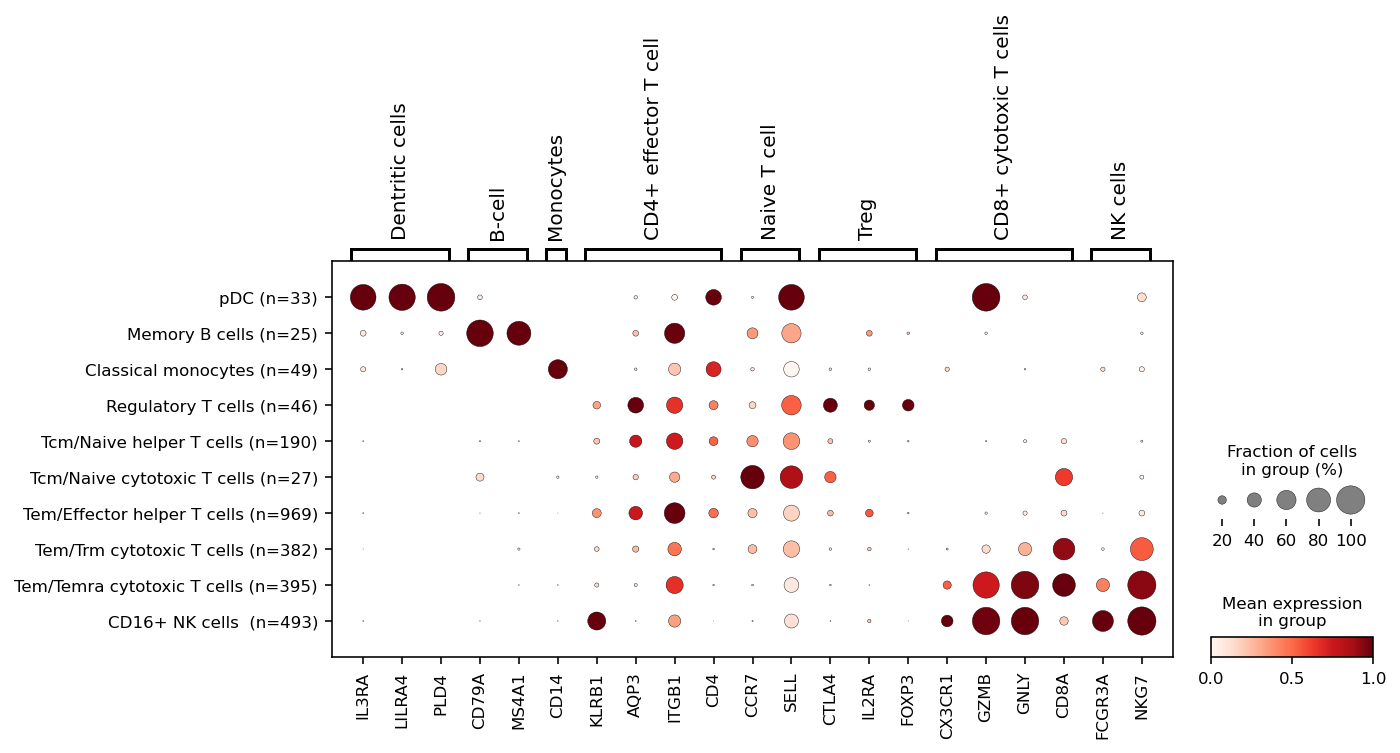

In [82]:
markers = { 
        "Dentritic cells":["IL3RA","LILRA4","PLD4"],
        "B-cell": ['CD79A','MS4A1'], #B cells
        "Monocytes": ['CD14'],
            "CD4+ effector T cell":['KLRB1','AQP3','ITGB1','CD4'], # CD4+ helper T cell
            "Naive T cell":['CCR7','SELL'],
            "Treg":['CTLA4','IL2RA','FOXP3'],
            "CD8+ cytotoxic T cells":['CX3CR1','GZMB','GNLY','CD8A'],  
            "NK cells": ['FCGR3A','NKG7']
        } 

sc.pl.dotplot( 
    adata,
    markers,
    categories_order=["pDC (n=33)","Memory B cells (n=25)","Classical monocytes (n=49)","Regulatory T cells (n=46)",
    "Tcm/Naive helper T cells (n=190)","Tcm/Naive cytotoxic T cells (n=27)","Tem/Effector helper T cells (n=969)",
    "Tem/Trm cytotoxic T cells (n=382)","Tem/Temra cytotoxic T cells (n=395)","CD16+ NK cells  (n=493)"],
    groupby="cell_type_exp_n",save='10X_cellTypist_markers.'+imageFormat,
    standard_scale='var'
)

#### TCR data analysis
#### 1. QC analysis

Fraction of cells with more than one pair of TCRs: 0.03
Fraction of cells with one pair of TCRs: 0.41


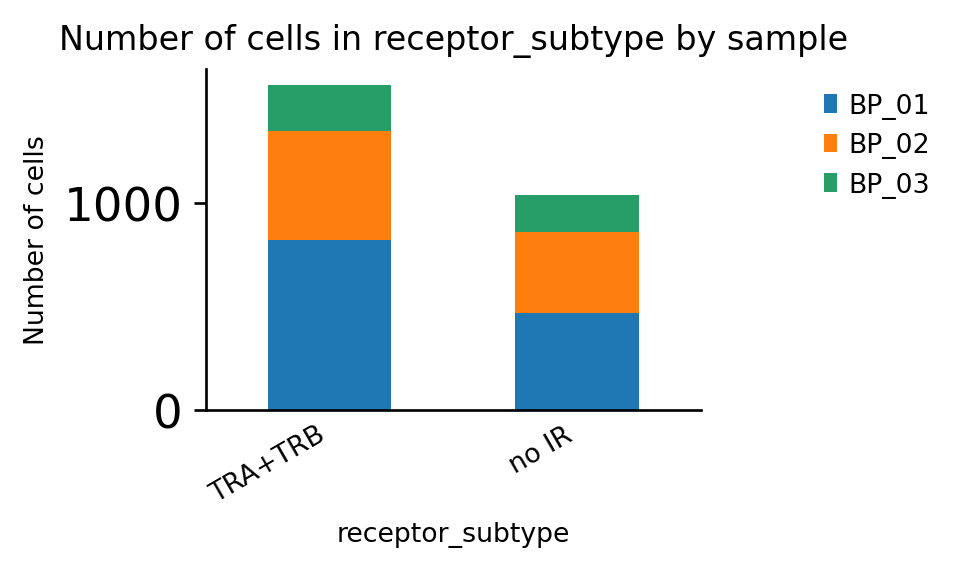

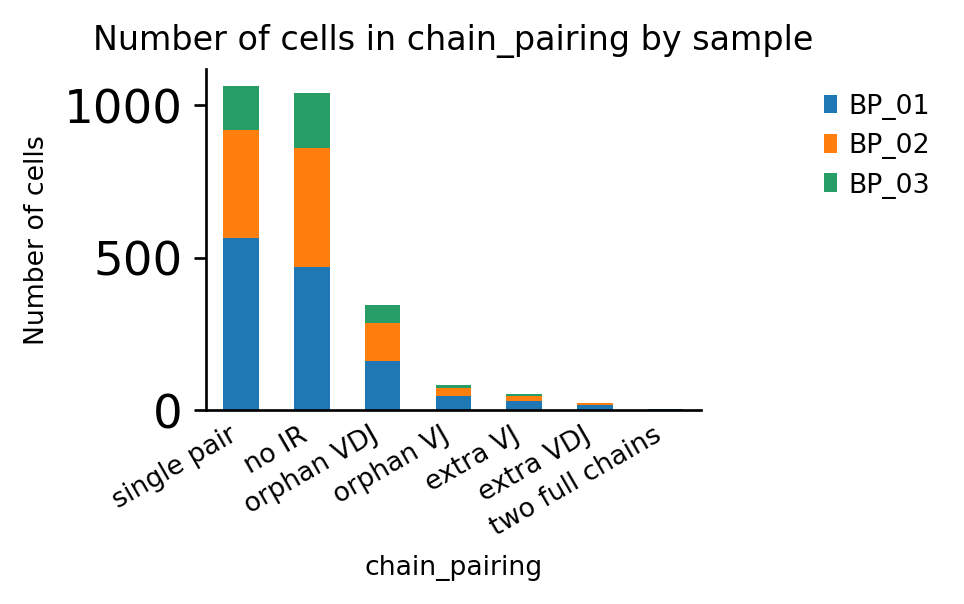

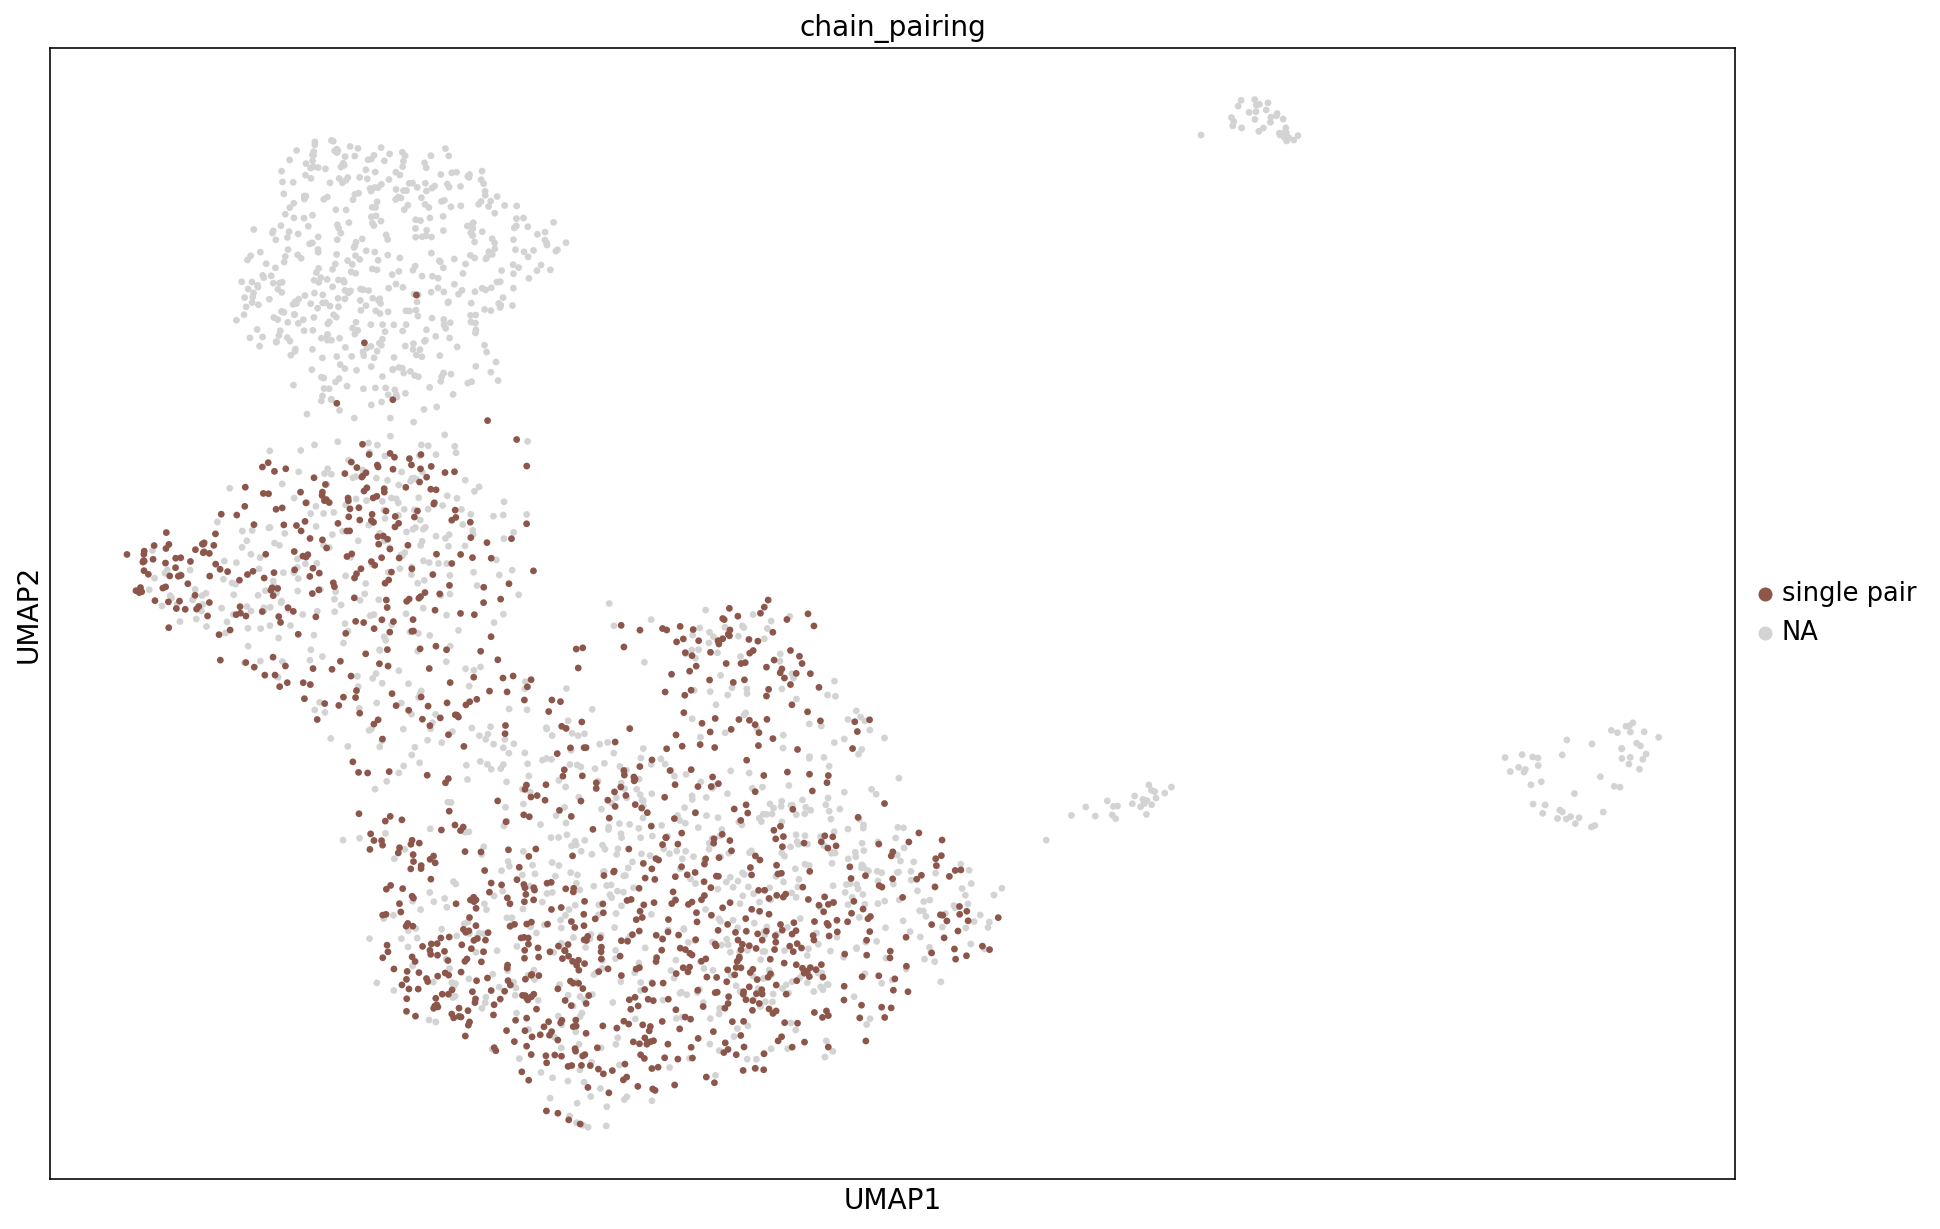

TCR FILTERING: cells with tcr = (2609, 10797)
TCR FILTERING: cells with 1 single pair of tcr = (1064, 10797)
BP_01 TCR FILTERING: cells with 1 single pair of tcr = (563, 10797)
BP_02 TCR FILTERING: cells with 1 single pair of tcr = (357, 10797)
BP_03 TCR FILTERING: cells with 1 single pair of tcr = (144, 10797)


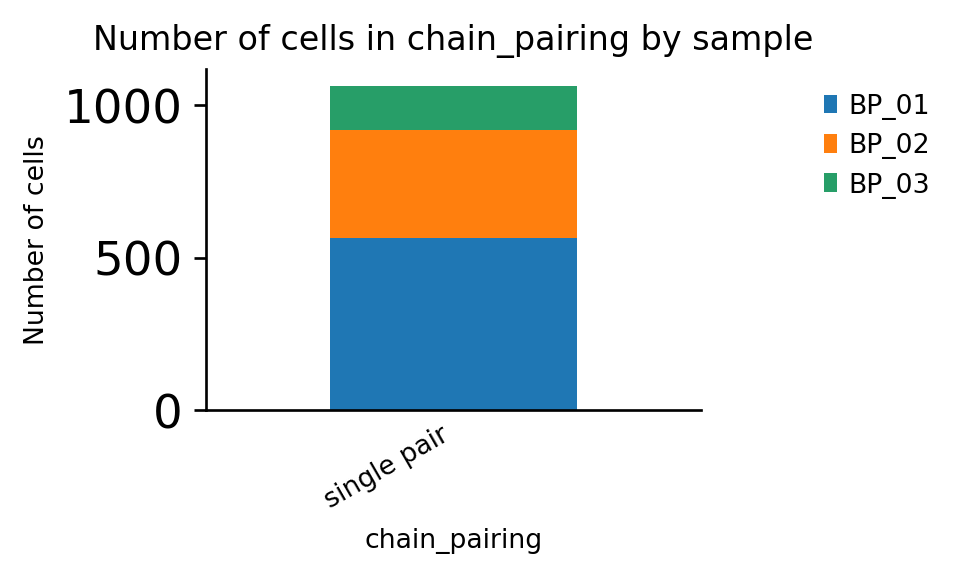

In [84]:
sc.settings.figdir=irdir

#1. Do some QC analysis
adata=adata_with_prediction
adata.obs.rename(columns={"majority_voting": "cell_type"}, inplace=True)
ir.tl.chain_qc(adata)
ax = ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="sample")
fig = ax.get_figure()
fig.savefig(irdir+'/receptorSubtype.'+imageFormat, bbox_inches='tight')
ax = ir.pl.group_abundance(adata, groupby="chain_pairing", target_col="sample")
fig = ax.get_figure()
fig.savefig(irdir+'/chainPairing_beforeFiltering.'+imageFormat, bbox_inches='tight')
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(
            adata.obs["chain_pairing"].isin(
                ["extra VJ", "extra VDJ", "two full chains"]
            )
        )
        / adata.n_obs
    )
)
print(
    "Fraction of cells with one pair of TCRs: {:.2f}".format(
        np.sum(
            adata.obs["chain_pairing"].isin(
                ["single pair"]
            )
        )
        / adata.n_obs
    )
)

#To visualize Multichain-cells on the UMAP plot
sc.pl.umap(adata, color="chain_pairing", groups="single pair", save='_multichain.'+imageFormat)

#We remove no IR cell
adata = adata[adata.obs["chain_pairing"] != "no IR", :].copy()
print("TCR FILTERING: cells with tcr =", adata.shape)

#We keep only single pair and productive
adata = adata[adata.obs["chain_pairing"] == "single pair", :].copy()
print("TCR FILTERING: cells with 1 single pair of tcr =", adata.shape)

#We count how many single pair TCR cell we have for each sample/donor
print("BP_01 TCR FILTERING: cells with 1 single pair of tcr =", adata[adata.obs['sample'].isin(['BP_01'])].shape)
print("BP_02 TCR FILTERING: cells with 1 single pair of tcr =", adata[adata.obs['sample'].isin(['BP_02'])].shape)
print("BP_03 TCR FILTERING: cells with 1 single pair of tcr =", adata[adata.obs['sample'].isin(['BP_03'])].shape)


ax = ir.pl.group_abundance(adata, groupby="chain_pairing", target_col="sample")
fig = ax.get_figure()
fig.savefig(irdir+'/chainPairing_afterFiltering.'+imageFormat, bbox_inches='tight')

#### 2. Compute CDR3 neighborhood graph and define clonotypes

  0%|          | 0/884 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/884 [00:00<?, ?it/s]

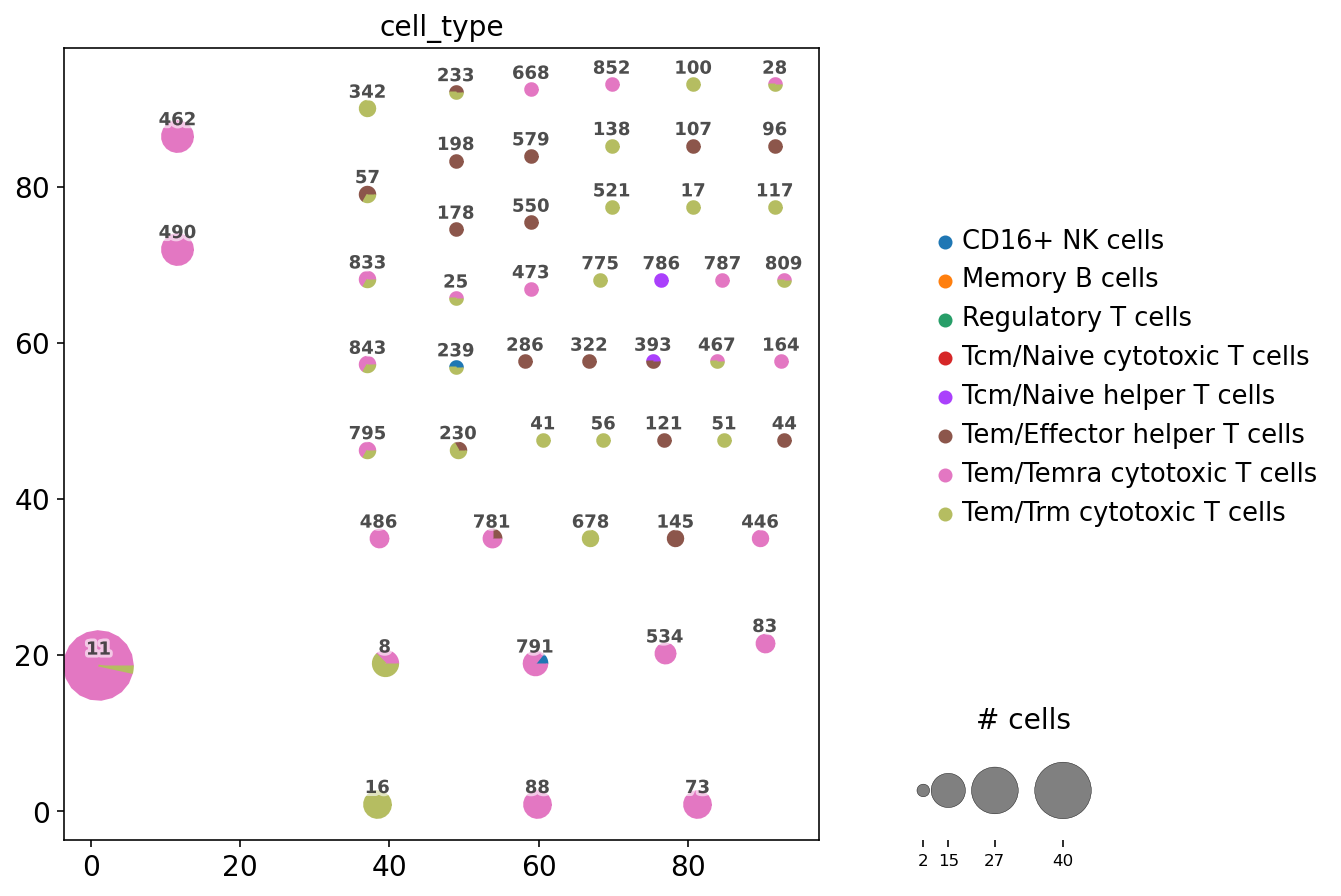

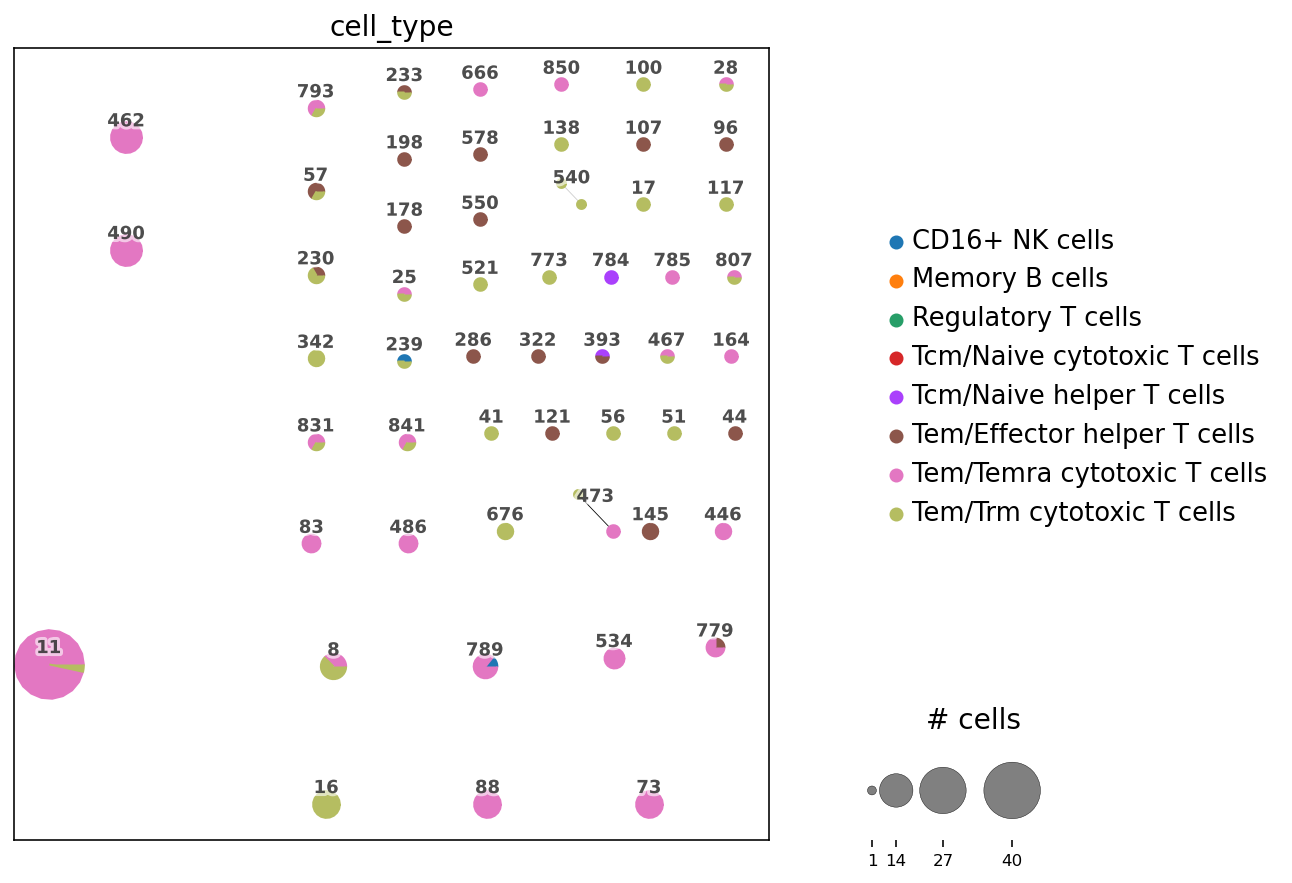

In [85]:
#Make a clonotype plot for each sample or all together but color by cell type
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(adata, min_cells=2) #we remove singleton
ax = ir.pl.clonotype_network(
    adata, color="cell_type", base_size=20, label_fontsize=9, panel_size=(7, 7)
)
fig = ax.get_figure()
fig.savefig(irdir+'/clonotype_network_byCellType.'+imageFormat, bbox_inches='tight')

#3.Re-compute CDR3 neighborhood graph and define clonotype clusters
ir.pp.ir_dist(
    adata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)
#we define clonotype clusters (to add the same V gene for the clustering?)
ir.tl.define_clonotype_clusters(
    adata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="primary_only",
     #same_v_gene=True, key_added="cc_aa_alignment_same_v"
)
ir.tl.clonotype_network(adata, min_cells=2, sequence="aa", metric="alignment")
ax = ir.pl.clonotype_network(
    adata, color="cell_type", label_fontsize=9, panel_size=(7, 7), base_size=20
)
fig = ax.get_figure()
fig.savefig(irdir+'/clonotype_cluster_network_byCellType.'+imageFormat, bbox_inches='tight')



  0%|          | 0/884 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/884 [00:00<?, ?it/s]

IR_VJ_1_junction_aa IR_VDJ_1_junction_aa receptor_subtype  n_cells
0      CAATIGTGFQKLVF     CASRLTRETIADTQYF          TRA+TRB        1

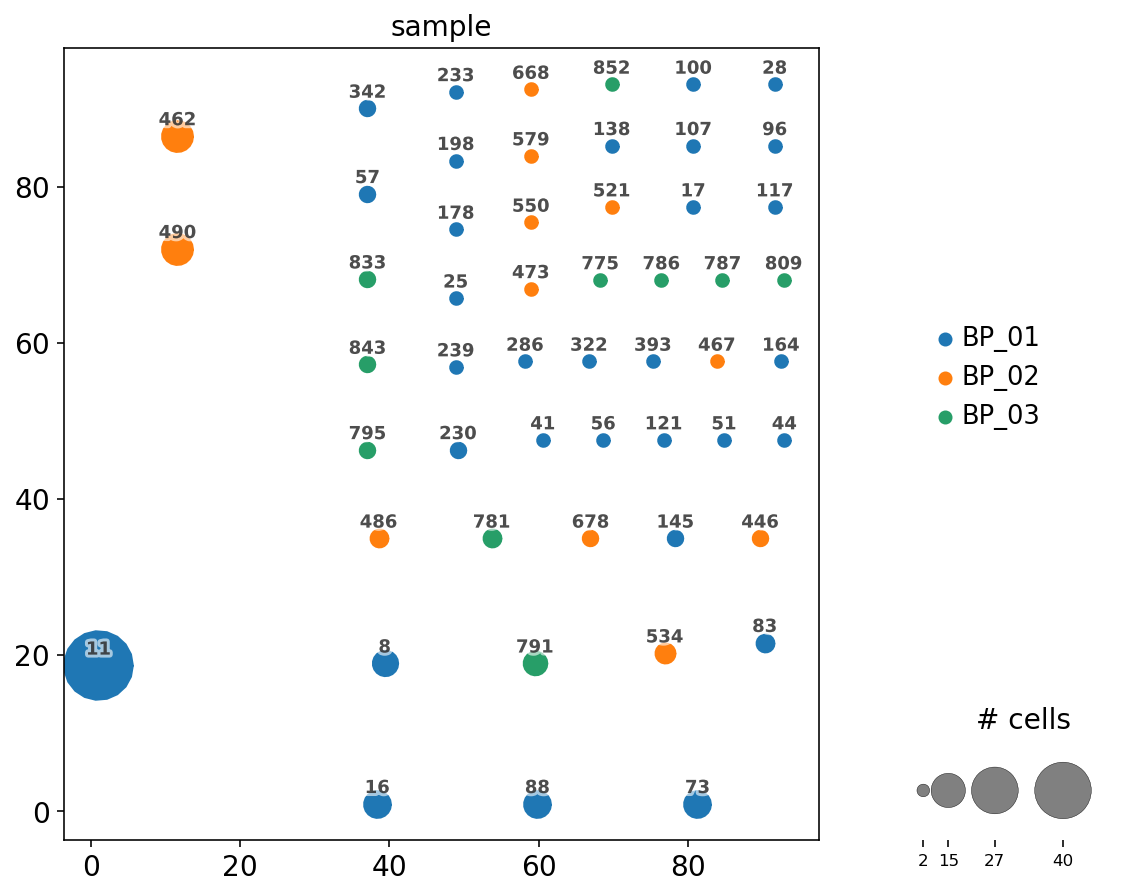

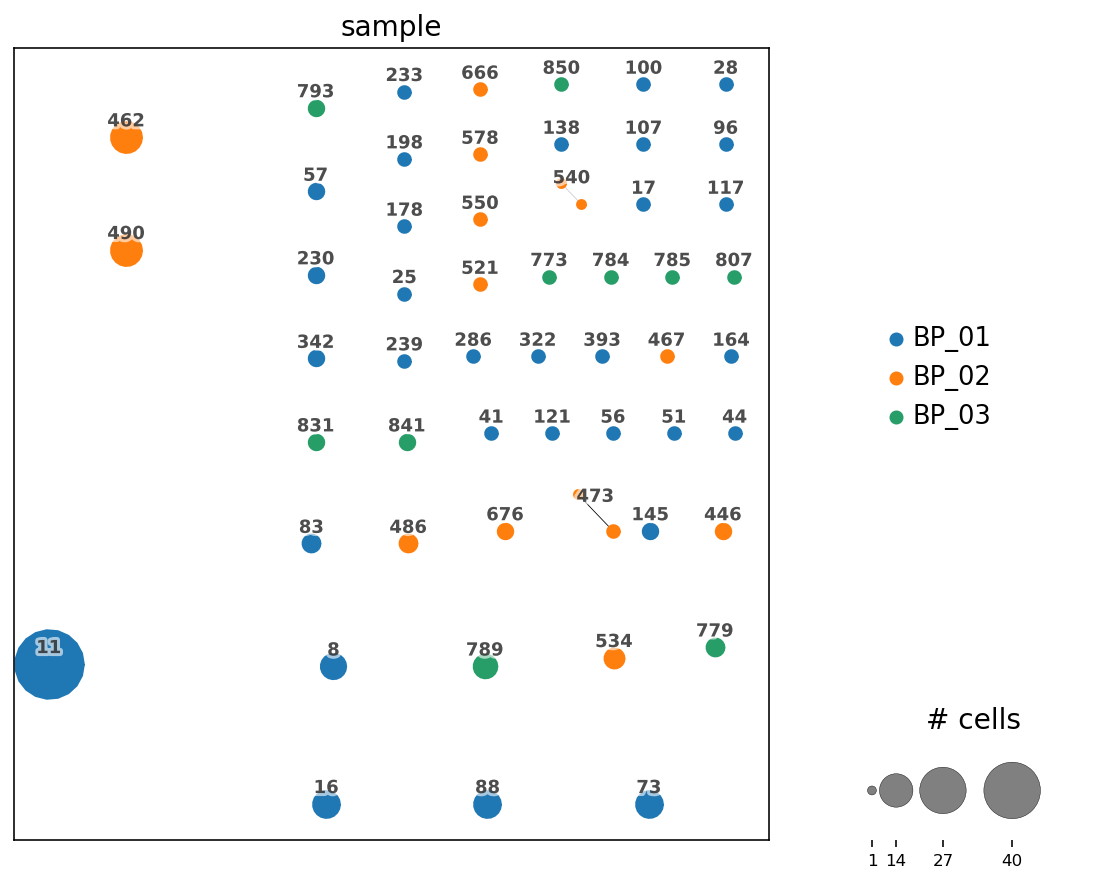

In [86]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(adata, min_cells=2) #we remove singleton
ax = ir.pl.clonotype_network(
    adata, color="sample", base_size=20, label_fontsize=9, panel_size=(7, 7)
)
fig = ax.get_figure()
fig.savefig(irdir+'/clonotype_network.'+imageFormat, bbox_inches='tight')

#3.Re-compute CDR3 neighborhood graph and define clonotype clusters
ir.pp.ir_dist(
    adata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)
#we define clonotype clusters (to add the same V gene for the clustering?)
ir.tl.define_clonotype_clusters(
    adata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="primary_only",
     #same_v_gene=True, key_added="cc_aa_alignment_same_v"
)
ir.tl.clonotype_network(adata, min_cells=2, sequence="aa", metric="alignment")
ax = ir.pl.clonotype_network(
    adata, color="sample", label_fontsize=9, panel_size=(7, 7), base_size=20
)
fig = ax.get_figure()
fig.savefig(irdir+'/clonotype_cluster_network.'+imageFormat, bbox_inches='tight')

#Extract infor of a specific cluster (i.e. 96)
adata.obs.loc[adata.obs["cc_aa_alignment"] == "66", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VDJ_1_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

#### 3. Clonotype analysis

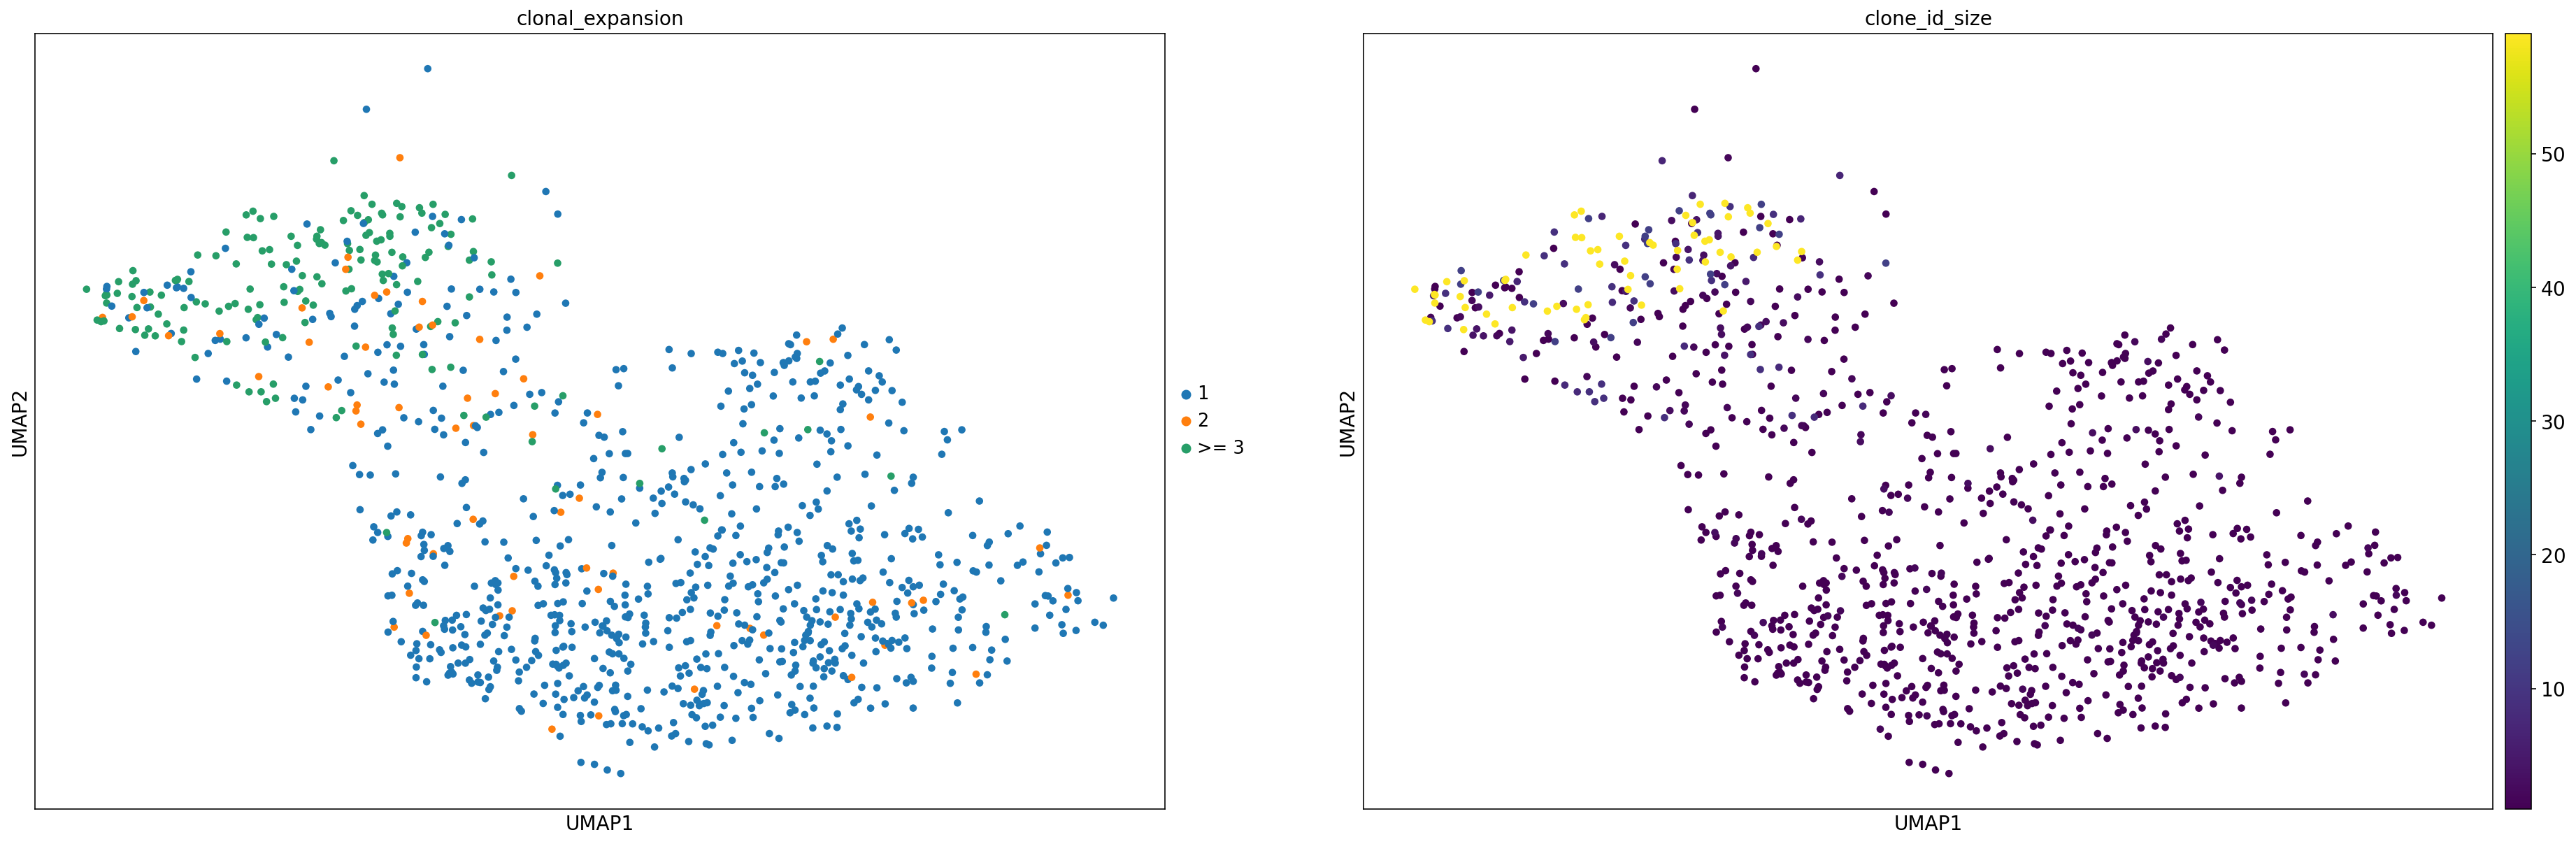

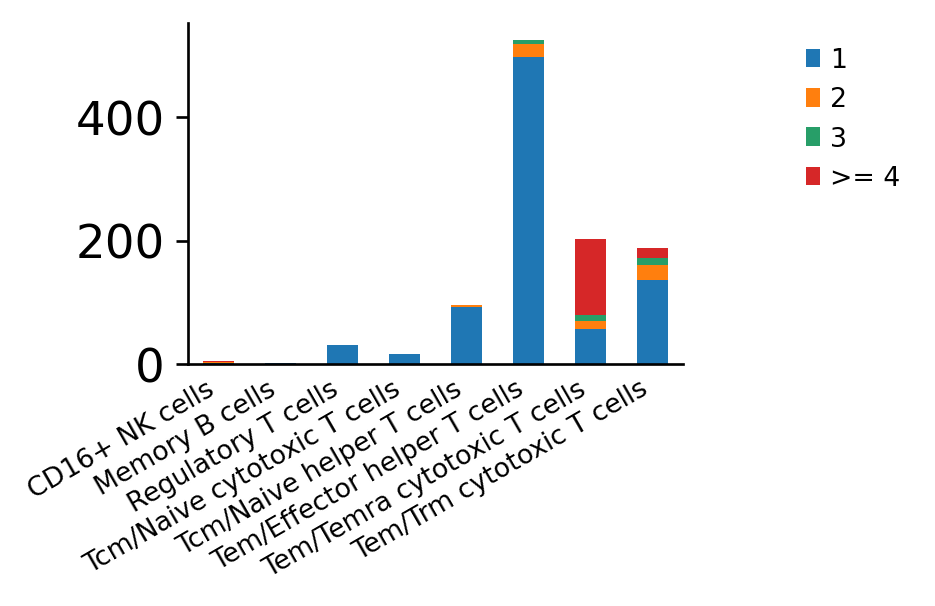

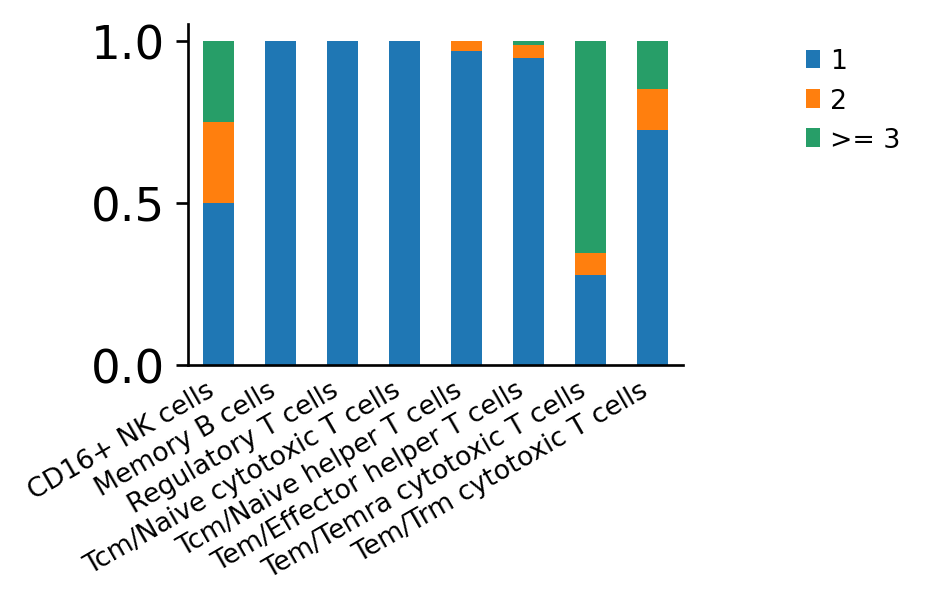

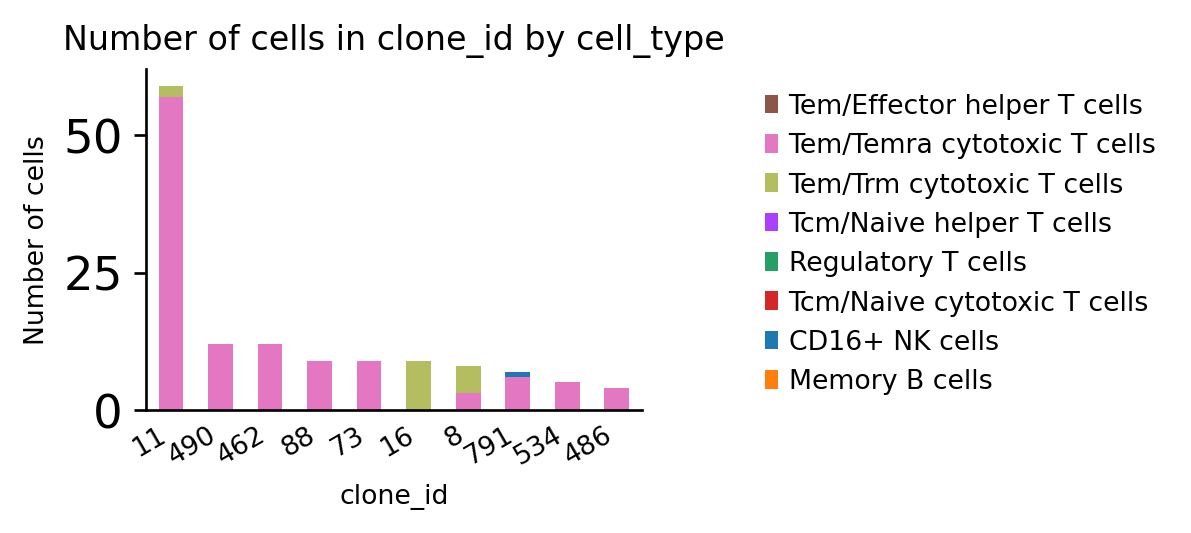

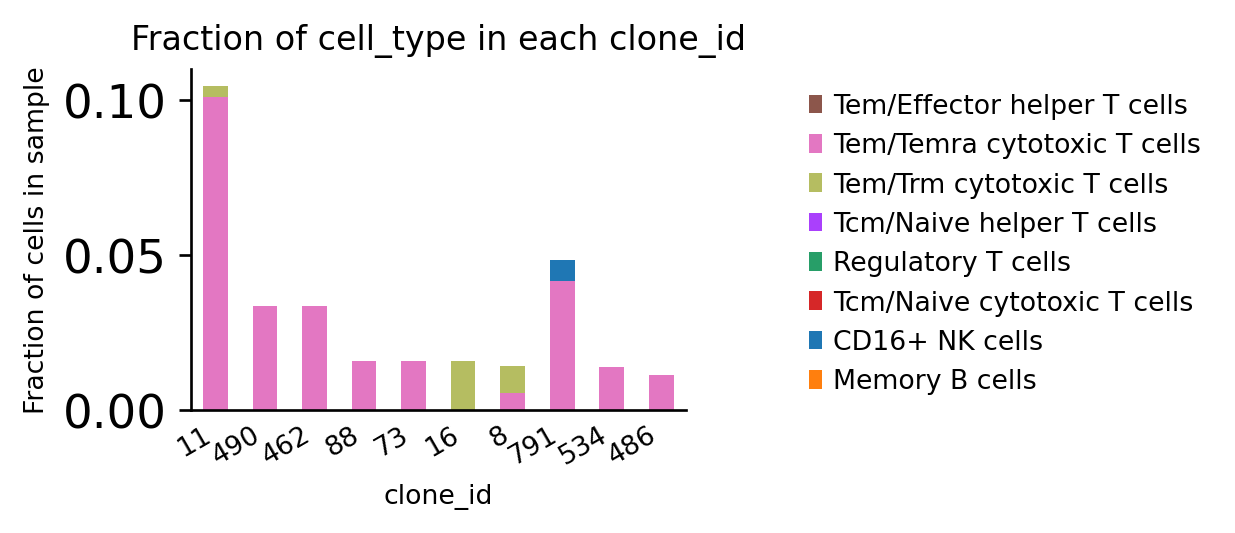

In [87]:
#5. Clonotype analysis
ir.tl.clonal_expansion(adata)
sc.pl.umap(adata, color=["clonal_expansion", "clone_id_size"], save='_clonalExpansion.'+imageFormat)

#We plot by GEX cluster
ax = ir.pl.clonal_expansion(adata, groupby="cell_type", clip_at=4, normalize=False)
fig = ax.get_figure()
fig.savefig(irdir+'/clonalExpansion_byGEX_cluster.'+imageFormat, bbox_inches='tight')
#if we normalize
ax = ir.pl.clonal_expansion(adata, "cell_type")
fig = ax.get_figure()
fig.savefig(irdir+'/clonalExpansion_byGEX_cluster_normalized.'+imageFormat, bbox_inches='tight')

#6. Clonotype abundance
#Show the top 10 clonotypes
ax = ir.pl.group_abundance(adata, groupby="clone_id", target_col="cell_type", max_cols=10)
fig = ax.get_figure()
fig.savefig(irdir+'/top10_clonotypes.'+imageFormat, bbox_inches='tight')
#normalized with sample size
ax = ir.pl.group_abundance(
    adata, groupby="clone_id", target_col="cell_type", max_cols=10, normalize="sample"
)
fig = ax.get_figure()
fig.savefig(irdir+'/top10_clonotypes_normalized.'+imageFormat, bbox_inches='tight')

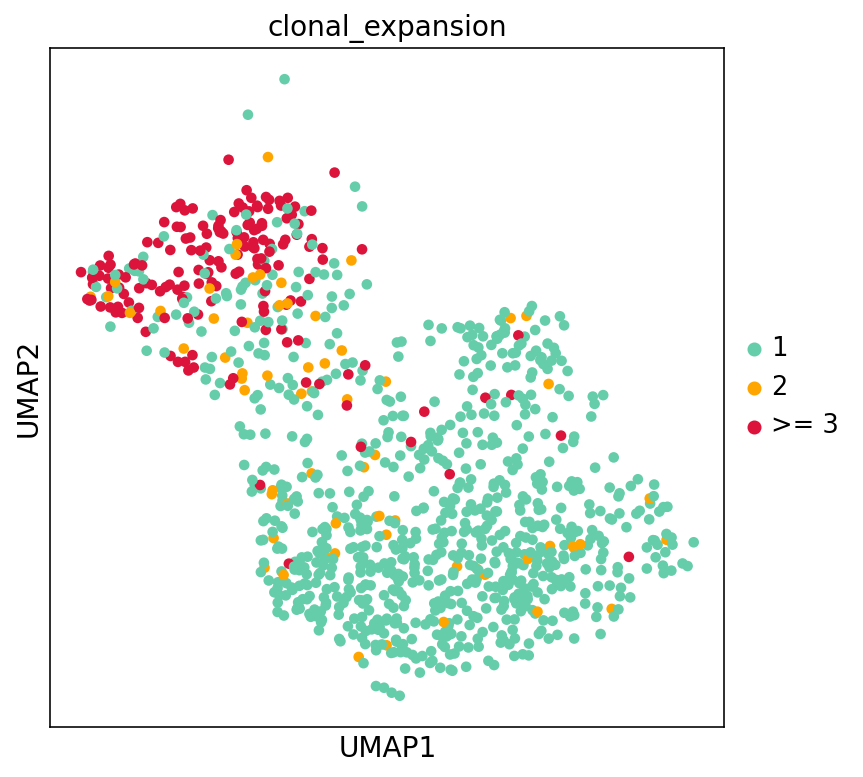

In [88]:
# Color in the UMAP the clonotype size
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color=["clonal_expansion"], 
    palette={
        "1": "mediumaquamarine",
        "2": "orange",
        ">= 3": "crimson",
        "nan": "gainsboro",
    },save='_clonalExpansion_V2.'+imageFormat)

#### 4. Analyzing clonotype

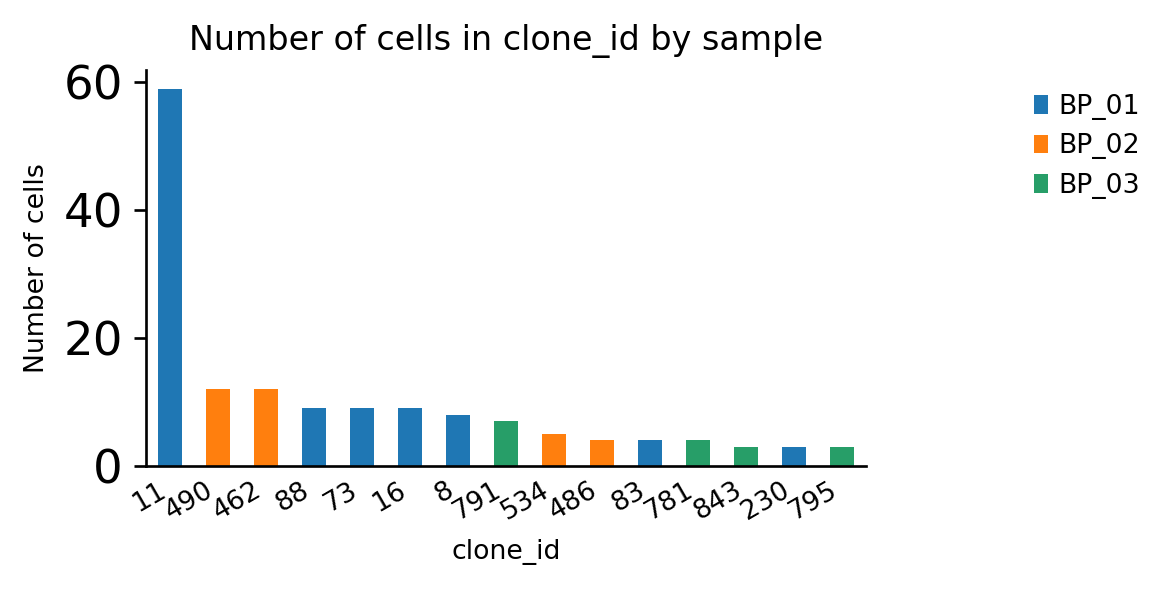

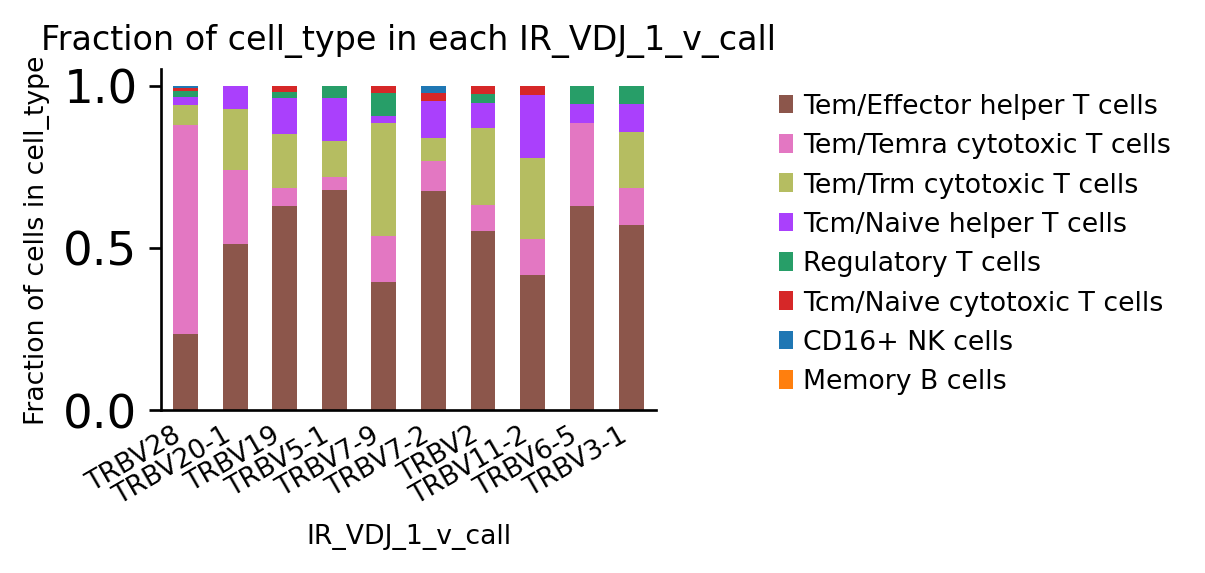

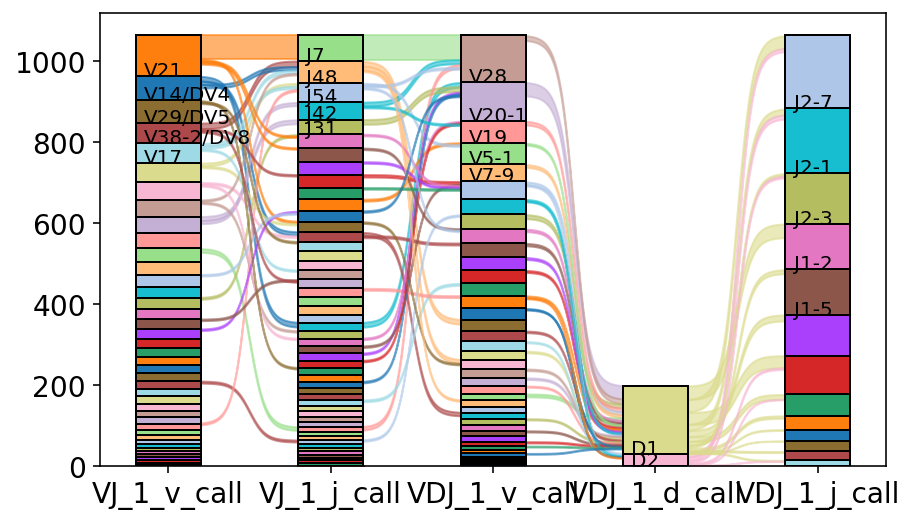

In [89]:
ax = ir.pl.group_abundance(
    adata, groupby="clone_id", target_col="sample", max_cols=15, figsize=(5, 3)
)
fig = ax.get_figure()
fig.savefig(irdir+'/top10_clonotypes_normalized.'+imageFormat, bbox_inches='tight')

#7. Gene usage
ax = ir.pl.group_abundance(
    adata, groupby="IR_VDJ_1_v_call", target_col="cell_type", normalize=True, max_cols=10
)
fig = ax.get_figure()
fig.savefig(irdir+'/geneUsage_by_GEX_cluster.'+imageFormat, bbox_inches='tight')

#VDJ combinations
ax = ir.pl.vdj_usage(adata, full_combination=False, max_segments=None, max_ribbons=30)
fig = ax.get_figure()
fig.savefig(irdir+'/VDJ_combination.'+imageFormat, bbox_inches='tight')



#### 5. Integrating GEX data

  0%|          | 0/882 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

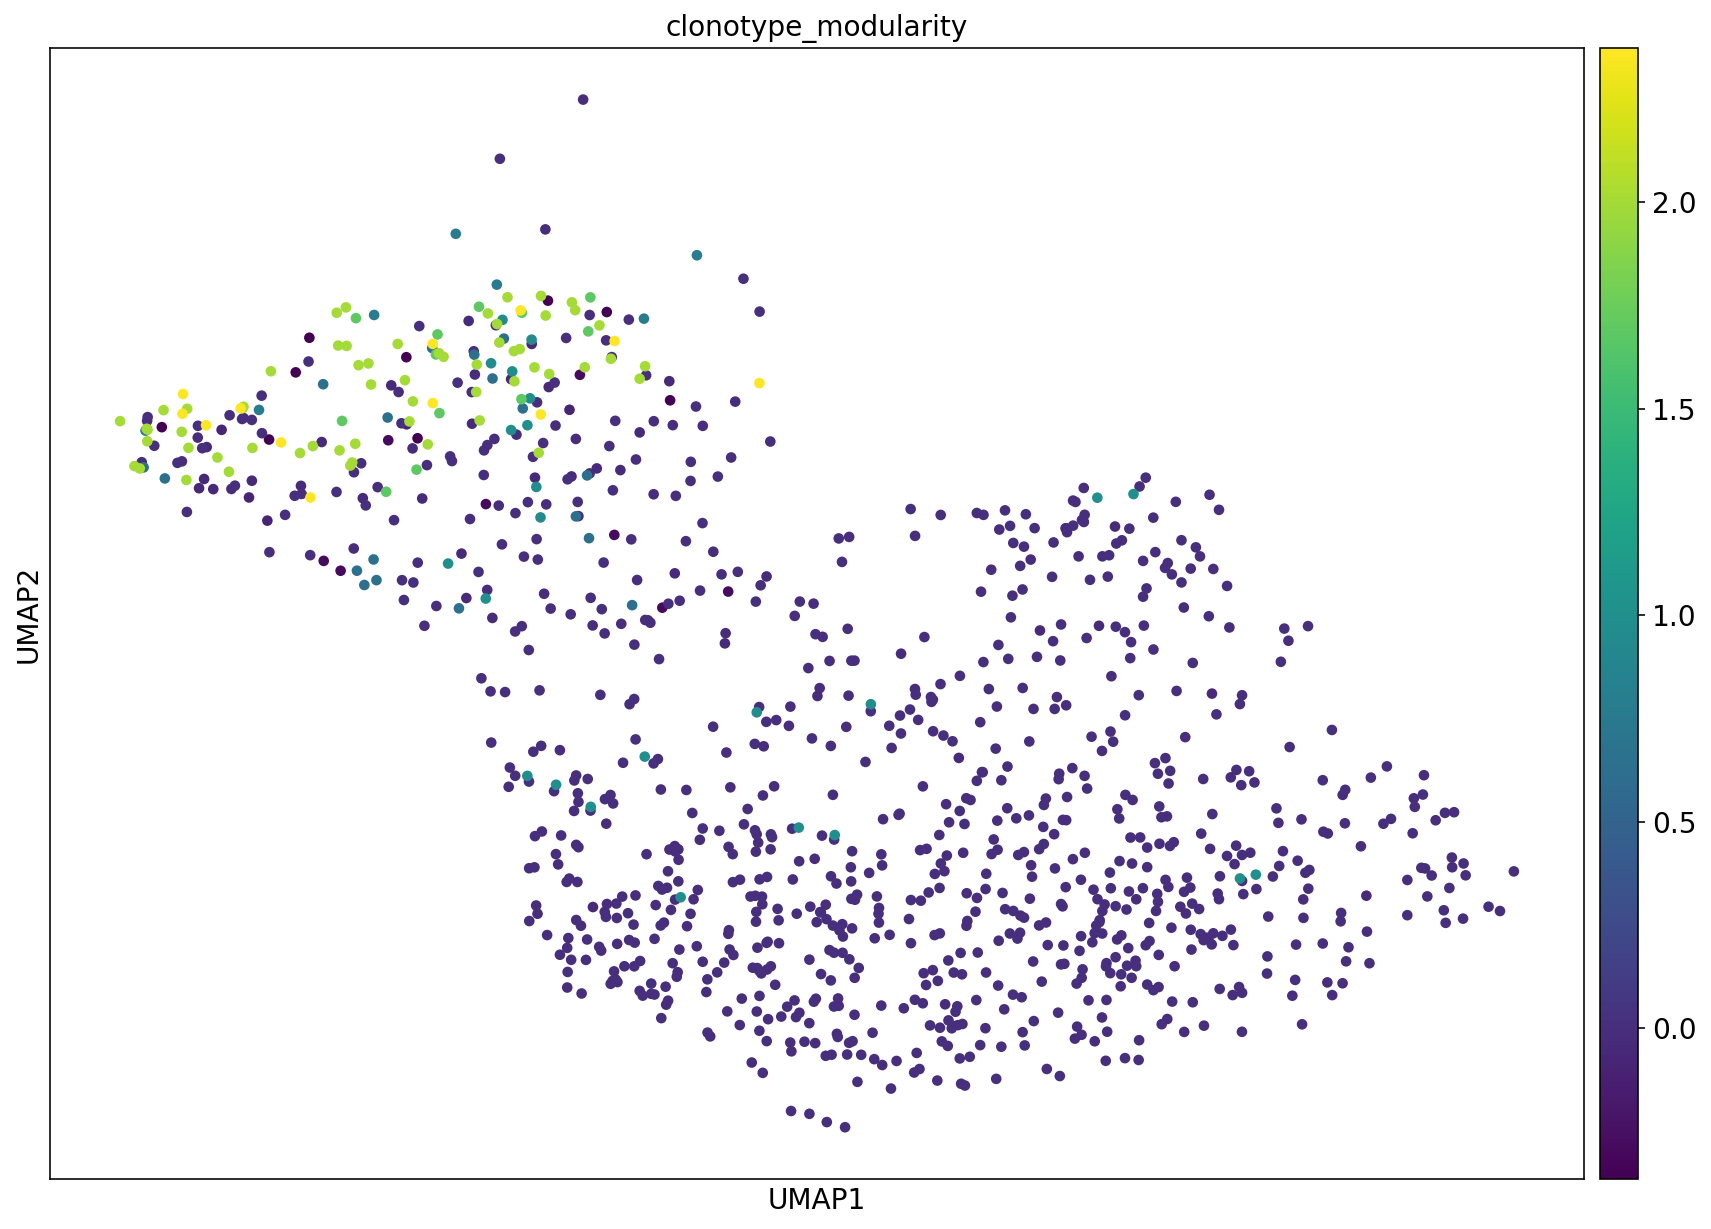

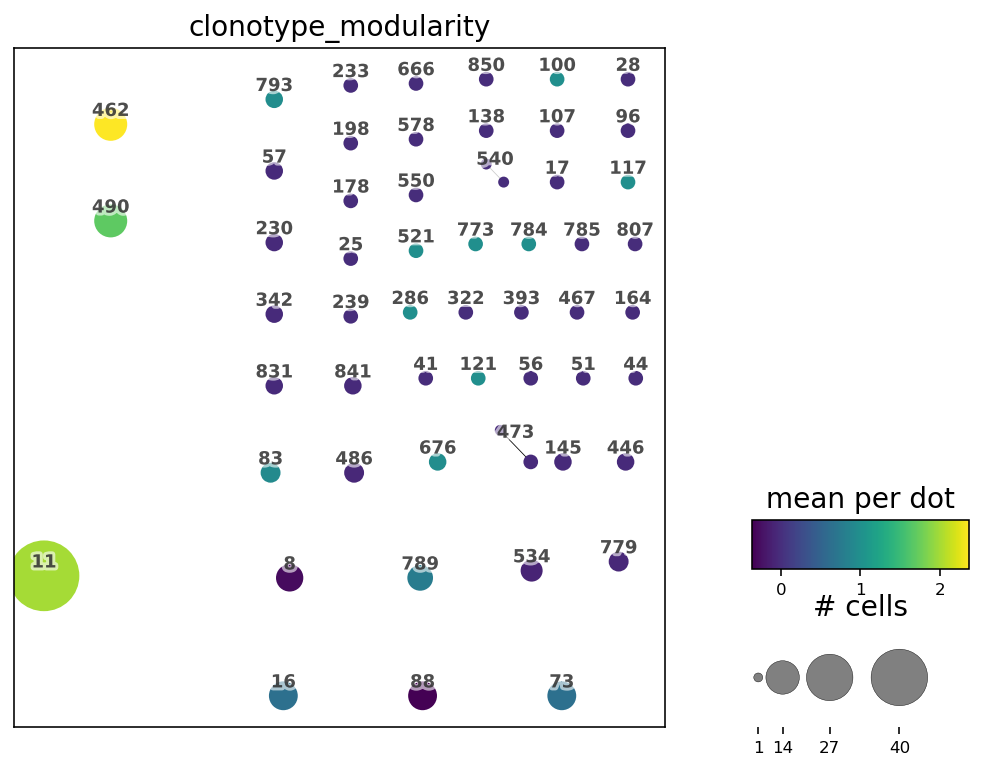

In [90]:
#Clonotype modularity
#To identify clonotypes that have cells with similar transcriptome
ir.tl.clonotype_modularity(adata, target_col="cc_aa_alignment")
sc.pl.umap(adata, color="clonotype_modularity", save='_clonotypeModularity.'+imageFormat)
ax = ir.pl.clonotype_network(
    adata,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=20,
)
fig = ax.get_figure()
fig.savefig(irdir+'/clonotypeModularity_on_clonotype_network.'+imageFormat, bbox_inches='tight')

#Finally we write the AnnData object into AIRR format to use in other tools (i.e. : Immunarch)
ir.io.write_airr(adata, out_dir+'airrfile_data.tsv')

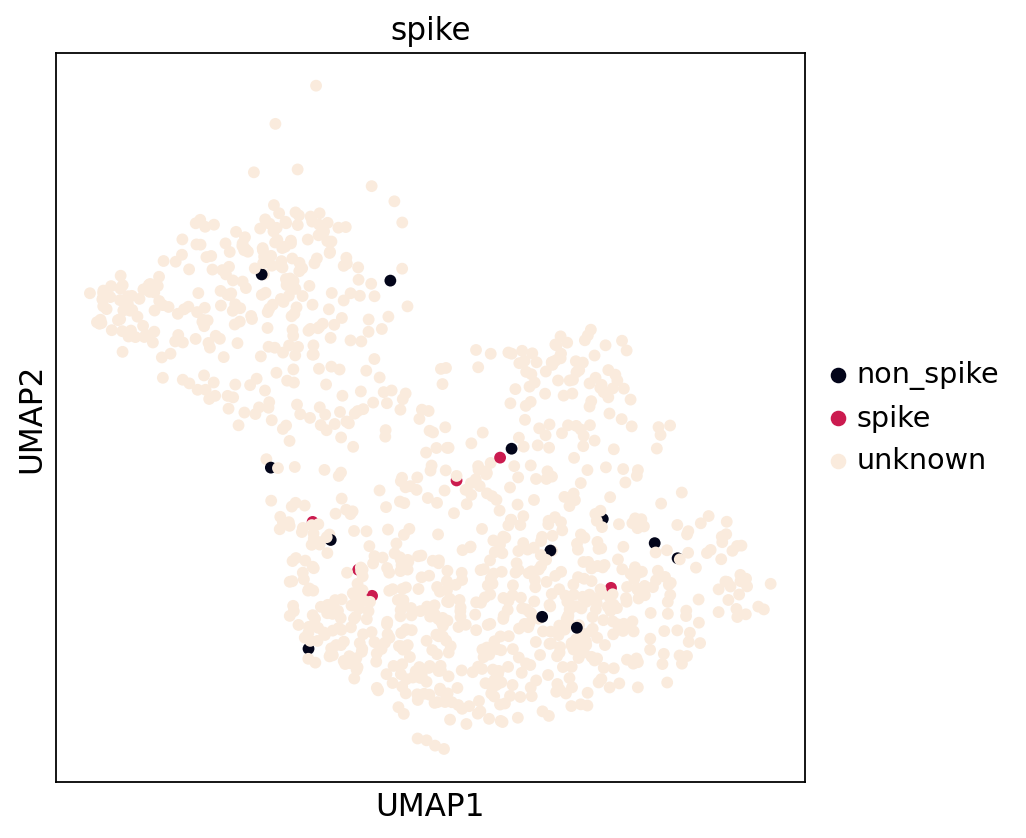

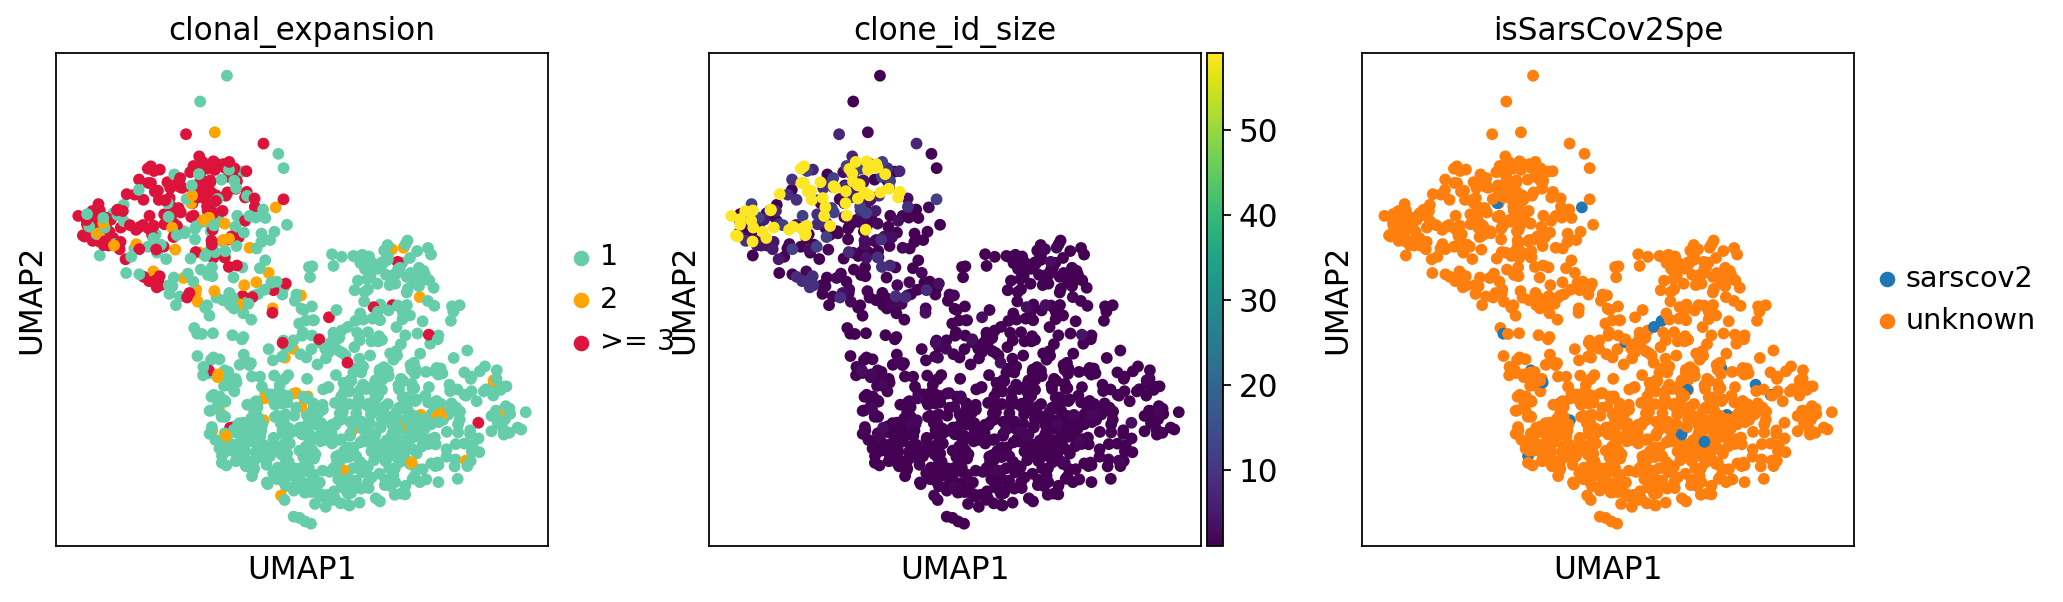

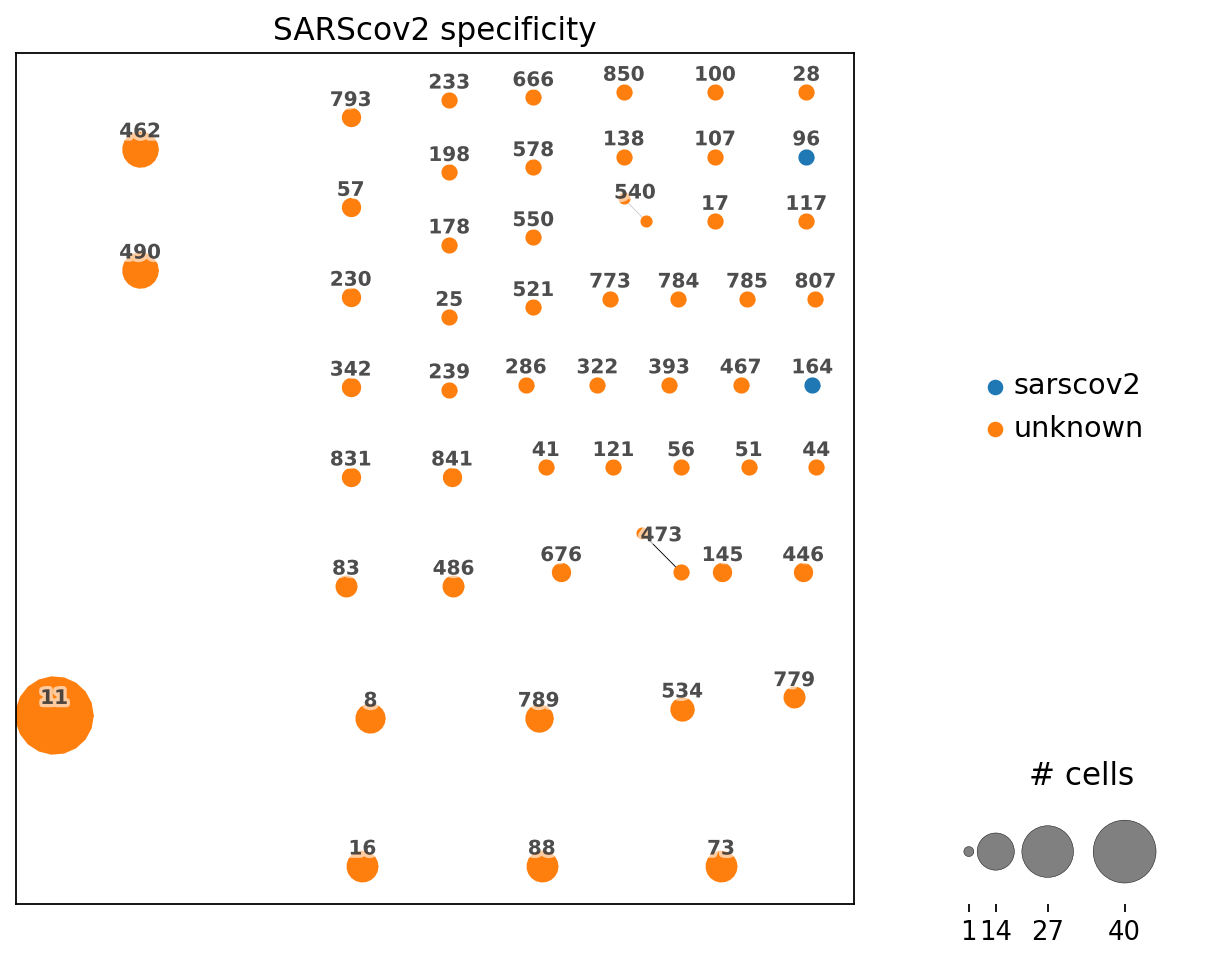

In [92]:


#We willclean the AIRR file with a Java class 'FromScirpyToAIRR'

#Get back the clonotypes with spike specificity information (file generated with 'LookForSpikeSpeTCR' Java class using VDJdb and MIRA database)
anno = pd.read_csv(processed_files_dir+'10X_airrfile_data_cleaned_cdr3_Vfamily_withHITs.tsv', sep='\t', header=0)

anno.set_index('barcode', inplace=True)
adata.obs['spike'] = anno['spike']
adata.obs['isSarsCov2Spe'] = anno['isSarsCov2Spe']


#Plot the Spike specific into UMAP plot
#from matplotlib.pyplot import rc_context
#with rc_context({'figure.figsize': (6, 6)}):
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, frameon=True, vector_friendly=False, fontsize=14,
                         figsize=(6, 6), color_map=None, format='svg', facecolor=None, transparent=False, ipython_format='png2x')
sc.pl.umap(
        adata,
        color="spike",
        palette="rocket",
        save='_spike_non_spike_Specific.svg'
    )

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, frameon=True, vector_friendly=True, fontsize=14,
                         figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
sc.pl.umap(adata, color=["clonal_expansion", "clone_id_size", "isSarsCov2Spe"], save='_clonalExpansion_sarscov2Spe.'+imageFormat)

### plot clonotypes cluster with the spike specificity
ax = ir.pl.clonotype_network(
    adata, title="SARScov2 specificity", color="isSarsCov2Spe", label_fontsize=9, panel_size=(7, 7), base_size=20
)
fig = ax.get_figure()
fig.savefig(irdir+'/clonotype_cluster_network_sarscov2Spe.'+imageFormat, bbox_inches='tight')

### Convert to html

In [ ]:

os.system('jupyter nbconvert --to html 10x_analyzeTcellFromBiopsy_PUB.ipynb')

[NbConvertApp] Converting notebook 10x_analyzeTcellFromBiopsy_PUB.ipynb to html
[NbConvertApp] Writing 9761586 bytes to 10x_analyzeTcellFromBiopsy_PUB.html


0